# Code Repeatability Part 3: EDA for Daily and Hourly Bitcoin Data + Bot Removal + Visualizations + Cross-Correlations + Sentiment Analysis + Linear Regression

## Summary

This notebook contains the rest of our work following the data cleaning, including EDA and the development of our data story.

First, we show visualizations for hourly and daily data for Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin' mentioned in Post. 

The next section includes initial sentiment analysis of the tweets using the VaderSentiment library. Seperate analysis was also conducted on Elon Musk's tweets. 

Next, new datasets for the daily and hourly data are created by removing the bots from the original datasets. This is done by manually looking at each of the 100 users who posted the most tweets and determining whether or not they were bots. If they appeared to be bots, their tweets were removed from the dataset. Then, users whose usernames contained phrases primarily used by bots were removed from the dataset. 

In the fourth section, we made better looking, more sophisticated visualizations, which we used in the data story.

In the fifth section, cross-correlation analysis was performed on each of the datasets (daily tweets with bots, hourly tweets with bots, daily tweets without bots, and hourly tweets without bots). There were a few cases where shifting the target variable time series back would increase the correlation by a small-to-moderate amount. This indicates that some features can be used to estimate future trends in the target variables.

In the last section, some linear regressions with visualizations were run on these promising variable pairs. Unfortunately, outliers had a significant effect on the trend lines that makes it clear that the time lag wasn't really improving the predictive power of these regressions.

# Table of Contents
[Section 1: Data Visualization](#Section-1:-Data-Visualization)
- [Summary/Key Findings](#Section-1:-Summary/Key-Findings)

[Section 2: Sentiment Analysis](#Section-2:-Sentiment-Analysis)
- [Summary/Key Findings](#Section-2:-Summary/Key-Findings)

[Section 3: Further Analysis/Data Visualization](#Section-3:-Further-Analysis/Data-Visualization)
- [Summary/Key Findings](#Section-3:-Summary/Key-Findings)

[Section 4: Final Visualizations Used in Data Story](#Section-4:-Final-Visualizations-Used-in-Data-Story)
- [Summary/Key Findings](#Section-4:-Summary/Key-Findings)

[Section 5: Cross Correlations](#Section-5:-Cross-Correlations)
- [Summary/Key Findings](#Section-5:-Summary/Key-Findings)

[Section 6: Linear Regression](#Section-6:-Linear-Regression)
- [Summary/Key Findings](#Section-6:-Summary/Key-Findings)

# Common Definitions Used
TotalCount - # of total interactions with a tweet (Including quotes, retweets, replies, and likes)

Closing Price - The closing price of bitcoin stock for the day and/or hour

Weighted Sentiment - A combination of total tweet interactions and the compound sentiment score for the tweet

In [1]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 2.7MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Section 1: Data Visualization
[Back to Table of Contents](#Table-of-Contents)

# Data Loading

### Load in Libraries and Data

In [2]:
# import libraries

# used for data carpentry
import pandas as pd
import numpy as np
import os

#dataviz
from plotnine import *
from matplotlib import gridspec
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
%matplotlib inline

# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# text cleaning
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# machine learning
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
os.getcwd()

'/dsa/home/bmgwd9/jupyter/casestudy_Group9/bmgwd9'

In [5]:
# change path variables
path = os.getcwd()
os.chdir('../../casestudy_data/group_9/')
new_path = os.getcwd()

In [6]:
# read in datasets
tweet = pd.read_csv("cleaned_tweets_and_close_prices.csv")

yahoo = pd.read_csv("daily_stock_last5yr.csv")

In [7]:
# change path back to original directory
os.chdir(path)

# Data Carpentry

### Subset Yahoo data to only Bitcoin

In [8]:
# subset yahoo data
yahoo = yahoo[["Date","Close","Volume","ticker"]]

In [9]:
# only keeping bitcoin ticker
yahoo = yahoo[yahoo['ticker'] == 'BTC-USD']

# sorting values from farthest date to most recent
yahoo = yahoo.sort_values('Date',ascending = True)

# resetting index
yahoo.reset_index(drop=True,inplace=True)

# creating a column that calculates the previous day close
yahoo['previous_day_close'] = yahoo.Close.shift()

# creating a feature that identifies if the price went up or down from the previous day's close
yahoo['target_increase'] = 0
yahoo.loc[(yahoo['Close'] - yahoo['previous_day_close']) > 0, 'target_increase'] = 1

In [10]:
# convert datatypes to dates
yahoo['Date'] = pd.to_datetime(yahoo['Date'])
tweet['Date'] = pd.to_datetime(tweet['Date'])

### Create additional columns in twitter dataset

In [11]:
# create column that takes the some of total interactions on a tweet
tweet['totalCount'] = tweet['replyCount'] + tweet['retweetCount'] + tweet['likeCount'] + tweet['quoteCount']

In [12]:
# subset twitter dataset
tweet_volumes = tweet[['replyCount','retweetCount','likeCount','quoteCount','totalCount','keyword_search','Date']]

# sum relevant like, reply, etc twitter counts by date and keyword
tweet_volumes = tweet_volumes.groupby(['Date','keyword_search']).sum().reset_index()

# pivot tweet volumes df
tweet_volumes = tweet_volumes.pivot(index='Date', columns='keyword_search',values = ['replyCount','retweetCount','likeCount','quoteCount','totalCount'])

# change from multi-index to single index columns
tweet_volumes.columns = ['_'.join(col) for col in tweet_volumes.columns.values]

# reset index
tweet_volumes = tweet_volumes.reset_index()

In [13]:
# group by date and keyword search to get number of tweets posted by specific keyword by date
tweetcounts = tweet.groupby(['Date','keyword_search']).count()['content']
tweetcounts = tweetcounts.reset_index()
tweetcounts = tweetcounts.rename({'content':'tweetCount'},axis=1)

# pivot tweet volumes df
tweetcounts = tweetcounts.pivot(index='Date', columns='keyword_search',values = 'tweetCount')
tweetcounts.columns = ['tweetCount_' + col for col in tweetcounts.columns]

### Merge Twitter and Yahoo data together

In [14]:
# merge datasets together
base = yahoo.merge(tweet_volumes, left_on='Date',right_on='Date')
base = base.merge(tweetcounts, left_on='Date',right_on='Date')

In [15]:
# convert Date to datetime datatype
base['Date'] = pd.to_datetime(base['Date'])

In [16]:
# fill in missing values with 0
base = base.fillna(0)

### Subset base (twitter + yahoo) dataframe to include only the bitcoin ticker symbol
### Creating additional columns for analysis

In [17]:
# creating a new dataframe only for bitcoin stock ticker
bitcoin = base[base['ticker']=='BTC-USD']

In [18]:
# Normalize the y-variables so they appear on the same scale
bitcoin['Close_norm'] = (bitcoin['Close']-bitcoin['Close'].min())/(bitcoin['Close'].max()-bitcoin['Close'].min())
bitcoin['totalCount_#BTC_norm'] = (bitcoin['totalCount_#BTC']-bitcoin['totalCount_#BTC'].min())/(bitcoin['totalCount_#BTC'].max()-bitcoin['totalCount_#BTC'].min())
bitcoin['totalCount_Bitcoin_norm'] = (bitcoin['totalCount_Bitcoin']-bitcoin['totalCount_Bitcoin'].min())/(bitcoin['totalCount_Bitcoin'].max()-bitcoin['totalCount_Bitcoin'].min())

In [19]:
# creating a datapoint that combines the total tweet interactions of tweets with #BTC or bitcoin referenced
bitcoin['totalCount_btc_or_bitcoin'] = bitcoin['totalCount_#BTC'] + bitcoin['totalCount_Bitcoin']

# normalize
bitcoin['totalCount_btc_or_bitcoin_norm'] = (bitcoin['totalCount_btc_or_bitcoin']-bitcoin['totalCount_btc_or_bitcoin'].min())/(bitcoin['totalCount_btc_or_bitcoin'].max()-bitcoin['totalCount_btc_or_bitcoin'].min())

In [20]:
# normalizing totalcount of tweet interactions with elon musk tweets
bitcoin['totalCount_elonmusk_norm'] = (bitcoin['totalCount_elonmusk']-bitcoin['totalCount_elonmusk'].min())/(bitcoin['totalCount_elonmusk'].max()-bitcoin['totalCount_elonmusk'].min())

# Data Visualization

### Plot Visuals comparing Bitcoin and total tweet counts

##  Plots below: Using DAILY yahoo finance dataset

In [21]:
# plot 1
p1 = (ggplot(bitcoin,aes(x='Date',group = 1))
 +geom_bar(aes(y='totalCount_#BTC_norm',fill="'steelblue'"),color='steelblue',stat='identity')
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +ggtitle("Closing Prices of Bitcoin Compare to # of Tweet Interactions with '#BTC' Mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Normalized Value')
 +scale_fill_identity(guide='legend', labels=['Total Tweet Interactions #BTC','Close Price of Bitcoin'],name='Legend')
 +theme_bw()
)

In [22]:
# plot 2
p2 = (ggplot(bitcoin,aes(x='Date',group = 1))
 +geom_bar(aes(y='totalCount_Bitcoin_norm',fill="'darkgreen'"),color='darkgreen',stat='identity')
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Normalized Value')
 +scale_fill_identity(guide='legend', labels=['Total Tweet Interactions Bitcoin','Close Price of Bitcoin'],name='Legend')
 +theme_bw()
)

In [23]:
# saving images
ggsave(plot = p1, filename = "plot1.jpg",width = 10,height = 10,units = "in")
ggsave(plot= p2, filename = "plot2.jpg",width = 10,height = 10,units = "in")

In [24]:
# opening images as plots
img = Image.open("plot1.jpg")
img2 = Image.open("plot2.jpg")

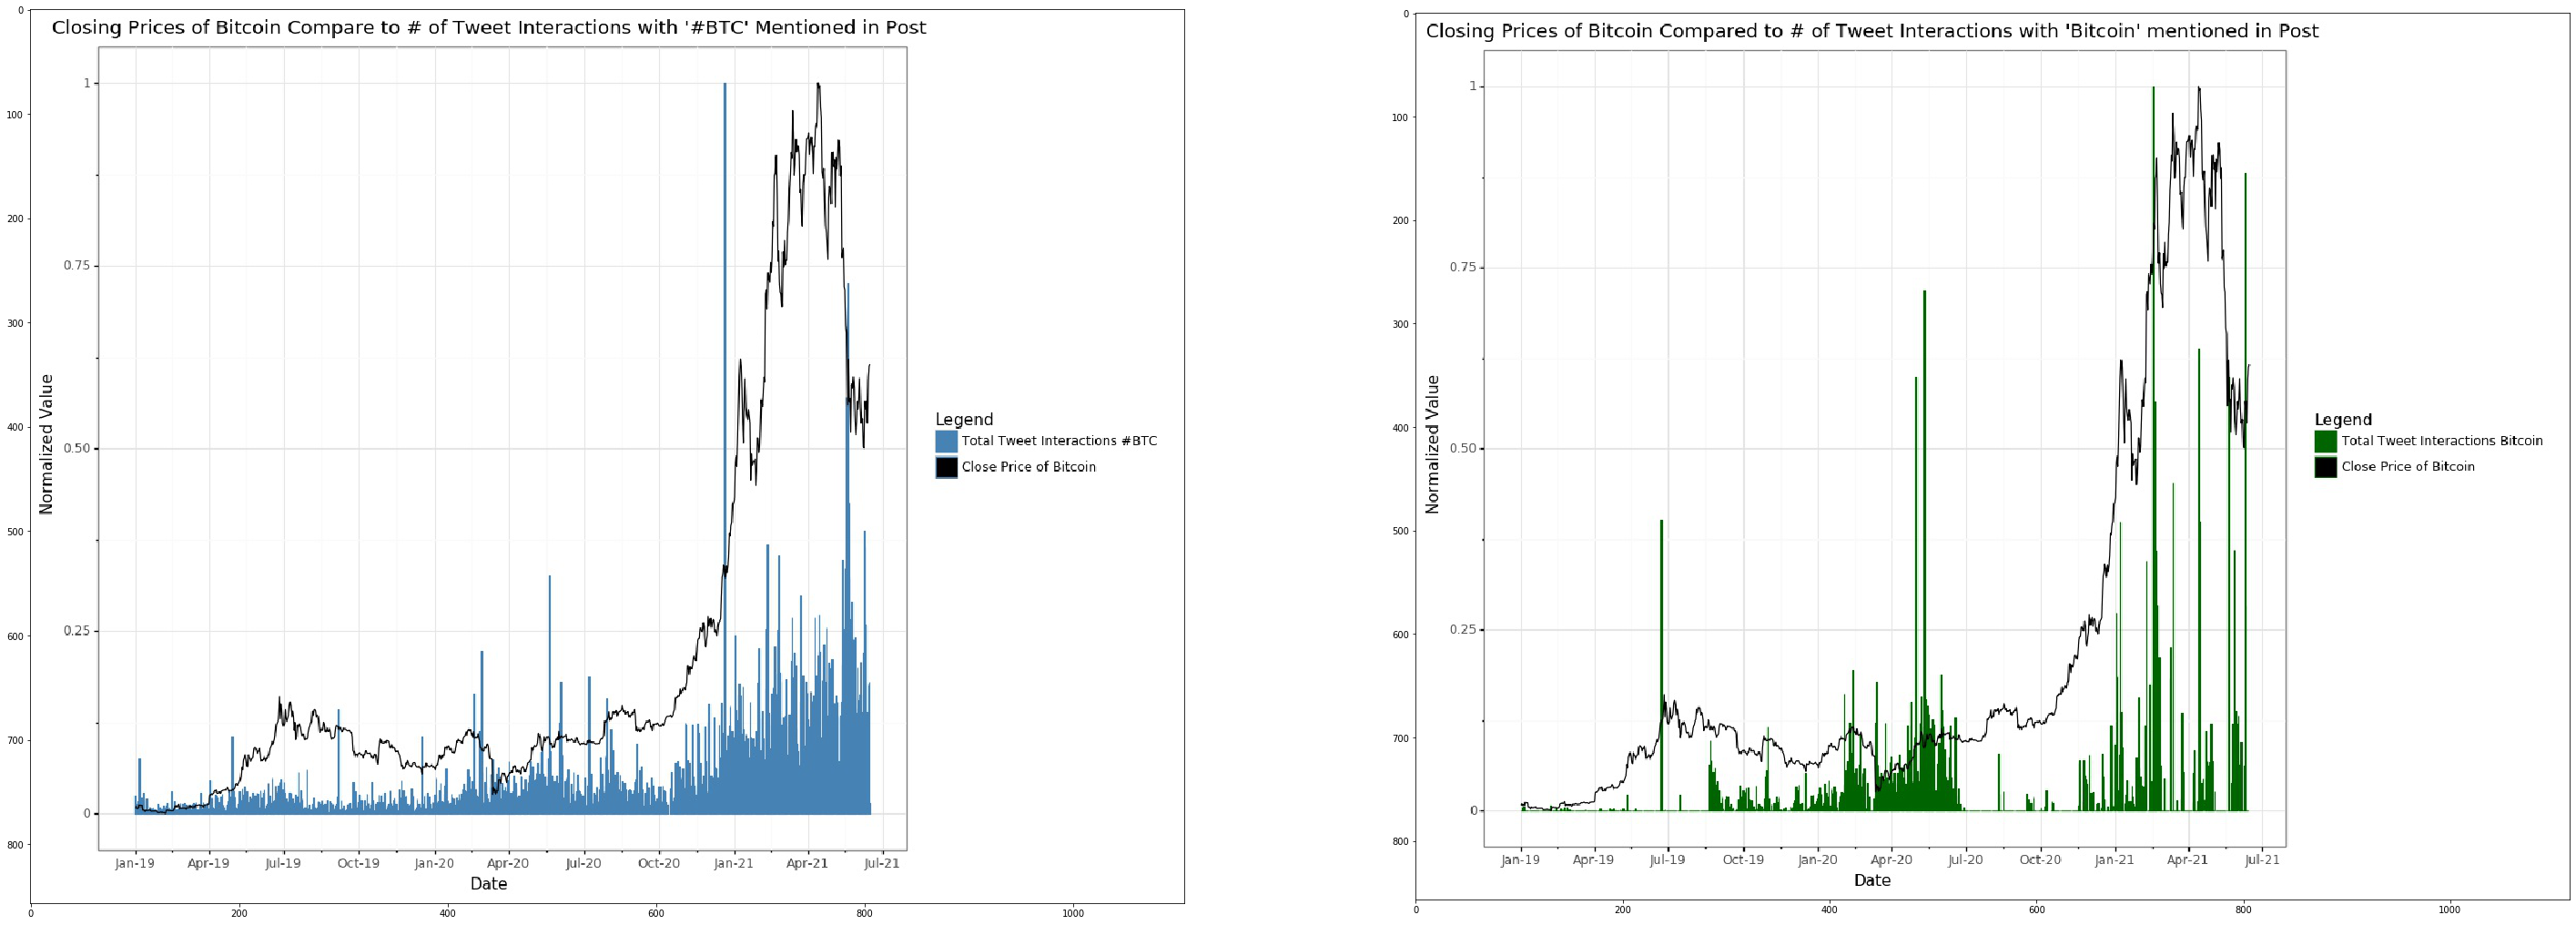

In [25]:
# comparing plot images for a side by side comparison
fig = plt.gcf()
fig.set_size_inches(50, 50)
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2)


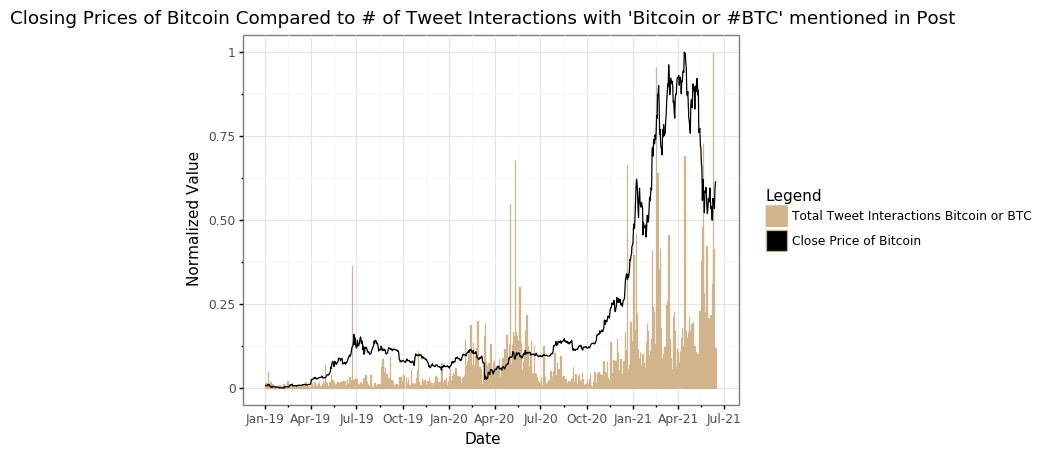

<ggplot: (8784347456811)>

In [26]:
# plot 3
p3 = (ggplot(bitcoin,aes(x='Date',group = 1))
 +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'tan'"),color='tan',stat='identity')
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Normalized Value')
 +scale_fill_identity(guide='legend', labels=['Total Tweet Interactions Bitcoin or BTC','Close Price of Bitcoin'],name='Legend')
 +theme_bw()
)
p3

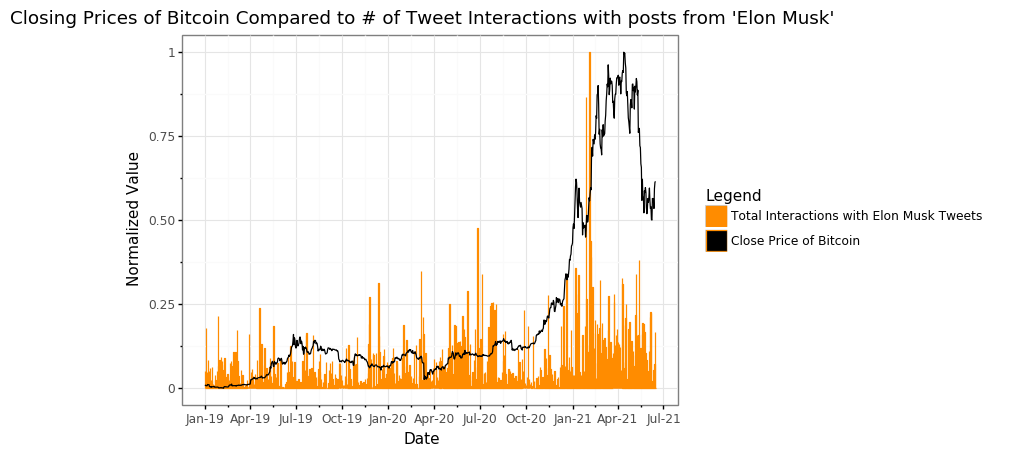

<ggplot: (-9223363252548592945)>

In [27]:
# plot 4
p4 = (ggplot(bitcoin,aes(x='Date',group = 1))
 +geom_bar(aes(y='totalCount_elonmusk_norm',fill="'darkorange'"),color='darkorange',stat='identity')
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with posts from 'Elon Musk'")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Normalized Value')
 +scale_fill_identity(guide='legend', labels=['Total Interactions with Elon Musk Tweets','Close Price of Bitcoin'],name='Legend')
 +theme_bw()
)
p4

## Section 1: Summary/Key Findings
[Back to Table of Contents](#Table-of-Contents)

There are some clear spikes in total # of interactions with tweets that include bitcoin or btc prior to the rise in bitcoin stock price. These visuals show there could be some potential correlation between tweet interactions and the change in bitcoin stock. The visual that compares total tweet interactions with bitcoin/btc tweets shows a spike in tweet interactions around may 2020 with bitcoin prices increasing around 6 months afters, steadily increasing from october 2020 - April 2021.

# ----------------------------End of Section 1----------------------------

# Section 2: Sentiment Analysis
[Back to Table of Contents](#Table-of-Contents)

## Data Carpentry

### Focusing on Tweets related to Bitcoin and BTC

In [28]:
# subsetting tweets by keyword search of BTC and bitcoin
bit = tweet.loc[tweet['keyword_search'].isin(['#BTC','Bitcoin'])]

# sorting values by tweets with the most interaction
bit = bit.sort_values('totalCount', ascending = False)

# dropping unneeded columns
bit = bit.drop([
    'lang',
    'contains_#TSLA',
    'contains_#DOGE',
    'contains_#GME',
    'contains_#AMC',
    'contains_#tesla',
    'contains_#dogecoin',
    'contains_#gamestop',
    'no_hashtag',
    'contains_$TSLA',
    'contains_$DOGE',
    'contains_$GME',
    'contains_$AMC',
    'no_cashtag',
],axis=1)

# reset index
bit.reset_index(drop = True,inplace=True)

#### Listing the top 5 tweets with most interactions with bitcoin or btc mentioned. Elon Musk and Michael Saylor's conversation ranked in the top 5

In [29]:
# listing top 5 tweets with most interactions with bitcoin or btc mentioned
bit.head(5)[['content','replyCount','retweetCount','likeCount','totalCount',
             'quoteCount','username','timestamp','Date','BTC-USD']]

,content,replyCount,retweetCount,likeCount,totalCount,quoteCount,username,timestamp,Date,BTC-USD
0,"$50,000.",1157,6737,50995,59578,689,Bitcoin,2021-02-16 04:21:22+00:00,2021-02-16,49199.871094
1,@elonmusk Bitcoin price is too low imo,304,1480,33322,35228,122,Bitcoin,2020-05-01 15:12:20+00:00,2020-05-01,8864.766602
2,🇸🇻 https://t.co/1MXcNFGbLB,595,4336,28710,33877,236,Bitcoin,2021-06-09 18:34:13+00:00,2021-06-09,37345.121094
3,"$60,000.",819,4023,27165,32458,451,Bitcoin,2021-03-13 14:46:08+00:00,2021-03-13,61243.085938
4,The future of Facebook's Libra coin https://t....,587,7441,19773,28740,939,Bitcoin,2019-06-22 07:20:27+00:00,2019-06-22,10701.691406


In [30]:
# initalize porterstemmer to change word to root form
ps = PorterStemmer()

# additional words to remove
additional_words = ['http','...','unknown']

# cleaning text function
def cleanupContent(df):
    # list of stopword and punctuation to be removed
    stop_words = set(stopwords.words('english') + list(string.punctuation) + additional_words) 
    
    # tokenizing words - putting strings into a list of lists
    tokens = [word_tokenize(word) for word in df['content']]
    
    # stemming word - reduces words to their root word or chops off the derivational affixes
    # Example: Connected/Connecting -> Connect
    stemmed = [[ps.stem(word) for word in token] for token in tokens]
    
    # Lower words, remove stopwords, remove punctuation, and remove words 2 or less characters
    cleanup = [[word.lower() for word in token if word not in stop_words and  len(word)>2] for token in stemmed]
    return cleanup

In [31]:
# cleaning text
bit['cleaned_text'] = cleanupContent(bit)

# converting cleaned lists back into string
bit['cleaned_text_string'] = [" ".join(string) for string in bit['cleaned_text']]

In [32]:
# Top ten most common words within btc and bitcoin tweets
from collections import Counter
p = Counter(" ".join(bit['cleaned_text_string']).split()).most_common(10)
result = pd.DataFrame(p, columns=['Word', 'Frequency'])
result

,Word,Frequency
0,btc,343382
1,bitcoin,139499
2,crypto,83138
3,wallet,73399
4,cryptocurr,57591
5,blockchain,56552
6,eth,53976
7,thi,46382
8,usd,45443
9,transfer,39449


#### Unsurprisingly, btc & bitcoin were the most common used words in the btc/bitcoin twitter dataset (I would be shocked if they were not). Other common crypto currencies or crypto related terminology were also in the most commmon words.

### Overview of VaderSentiment Library

The [VaderSentiment](https://github.com/cjhutto/vaderSentiment) library was used to create the compound sentiment scores. Athough certain text cleaning techniques are helpful for exploring frequency of words in texts, removing punctuation, capitalization, and other techniques can change the sentiment score of a sentence.

Based on the example below, one can see that the compound score with the exclamation and the removal of stopwords is the same. However, removing the punctuation lowers the compound score just slightly. This is because the VaderSentiment package already removes stopwords when performing the compound scoring and uses punctuation with context clues to provide a better sentiment score for the text.

The VaderSentiment scores work best with tokenized sentences. Since we are dealing with twitter data that has a character limit of 280, there could be certain tweets that have multiple sentences. As of right now, we will assume that a tweet is one token/sentence. Although, for later iterations - the sentiment scores could be improved if each tweet was tokenized based on the sentences in that tweet



In [33]:
# initalize text sentiment analyzer
sid = SentimentIntensityAnalyzer()

txt = "this is superb and awesome!"
print("With exclamation:",sid.polarity_scores(txt)['compound'])
txt = "this is superb and awesome"
print("Without exclamation:",sid.polarity_scores(txt)['compound'])
txt = "superb awesome!"
print("Removal of stopwords:",sid.polarity_scores(txt)['compound'])

With exclamation: 0.8588
Without exclamation: 0.8481
Removal of stopwords: 0.8588


#### Below is an example of why cleaning the text can actually skew the sentiment scores lower than anticipated. VaderSentiment uses context clues such as punctuation and location of words to provide a compound sentiment score to a text.

In [34]:
test = bit['content'][300]
print(test)
print("Compound score of raw text:",sid.polarity_scores(test)['compound'])
print("\n")
test2 = bit['cleaned_text_string'][300]
print(test2)
print("Compound score of cleaned text:",sid.polarity_scores(test2)['compound'])

"Of course, I hate the #Bitcoin success and I don’t welcome a currency that’s useful" - Charlie Munger https://t.co/AKEt3pbg4n

Relative to $BTC, over the past five years $BRK/A has been in a massive decline is keeps following to new lows. https://t.co/cKFl4E3Ovr
Compound score of raw text: 0.6249


cours hate bitcoin success welcom currenc use charli munger //t.co/aket3pbg4n rel btc past five year brk/a massiv declin keep follow new low //t.co/ckfl4e3ovr
Compound score of cleaned text: -0.2732


In [35]:
# creating a compound sentiment score per tweet
bit['sentiment_compound'] = [sid.polarity_scores(row)['compound'] for row in bit['content']]

# merge more yahoo data to btc/bitcoin twitter dataset
bit = bit.merge(yahoo[['Volume','Date','previous_day_close','target_increase']])

# creating a sentiment column that is weighted based on total interactions of that tweet (replies, likes, quotes, and retweets)
bit['sentiment_weighted'] = bit['totalCount'] * bit['sentiment_compound']

# sort values
bit = bit.sort_values('sentiment_weighted',ascending = False)
bit.reset_index(drop=True,inplace = True)

### Normalize Data

In [36]:
# subset data
bit_normalized = bit[['Date','totalCount','BTC-USD','sentiment_compound','sentiment_weighted','Volume','previous_day_close','target_increase']]

# normalize data
bit_sub = bit_normalized.iloc[:,1:]
bit_normalized.iloc[:,1:] =(bit_sub-bit_sub.min())/(bit_sub.max()-bit_sub.min())


# adding additional columns for max values of sentiment weight score and total counts by dates
bit_normalized_max = bit_normalized.groupby('Date').max().reset_index()[['Date','sentiment_weighted','totalCount']]
bit_normalized_max.columns = [col + '_max' if col not in ['Date'] else col for col in bit_normalized_max.columns]

# merging values to normalized dataset
bit_normalized = bit_normalized.merge(bit_normalized_max,how='left', on ='Date')

# dropping duplicates
bit_normalized_dd = bit_normalized.drop_duplicates('Date')

### More Data Visuals

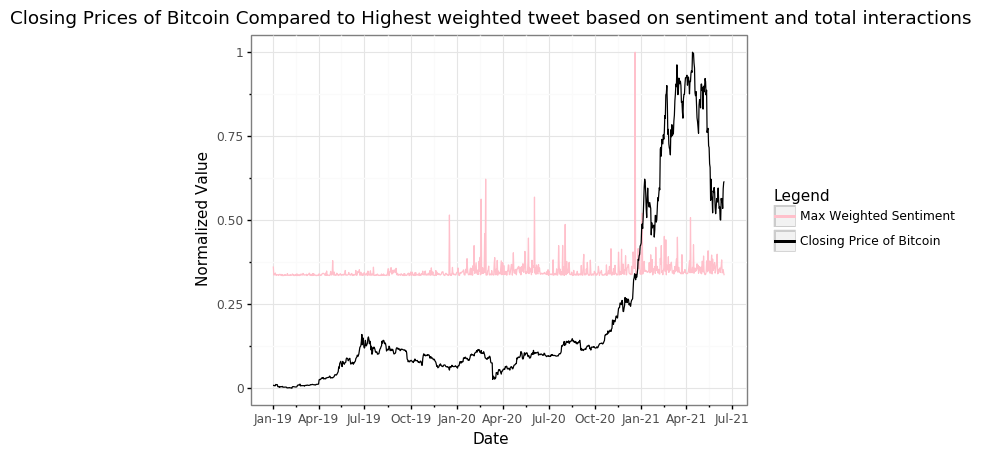

<ggplot: (8784065870891)>

In [37]:
p5 = (ggplot(bit_normalized_dd,aes(x='Date',group = 1))
 +geom_line(aes(y='sentiment_weighted_max',color="'pink'"),stat='identity')
 +geom_line(aes(y='BTC-USD',color="'black'"))
 +ggtitle("Closing Prices of Bitcoin Compared to Highest weighted tweet based on sentiment and total interactions")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Normalized Value')
 +scale_color_manual(values = ["pink","black"],labels = ["Max Weighted Sentiment", "Closing Price of Bitcoin"])
 +labs(color = "Legend")
 +theme_bw()
)
p5

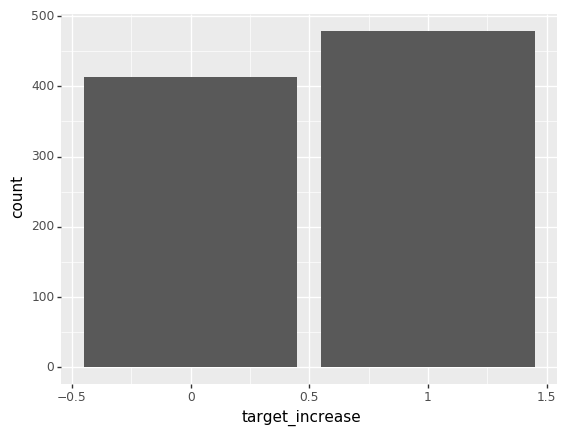

<ggplot: (-9223363252788904567)>

In [38]:
(ggplot(bit_normalized_dd)
 +geom_bar(aes('target_increase'))
)

### Correlation on Bit (bitcoin + btc) dataset

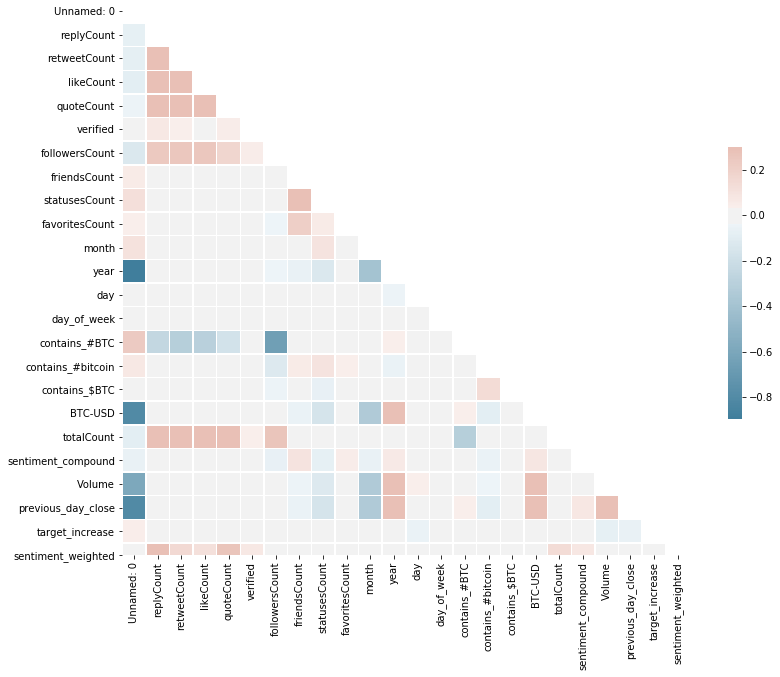

In [39]:
# Compute the correlation matrix
corr = bit.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

No super strong correlations with dataset that include bitcoin/btc tweets compared to target_increase or Bitcoin closing pricing. Weak positive correlation between Bitcoin price and volume of stock bought (not surprisingly)

## Sentiment Analysis

### Elon Musks tweets - Data Carpentry

In [40]:
# subsetting tweets to only elon musk tweets
elon = tweet[tweet['username']=='elonmusk']

# use custom function to clean tweets
elon['cleaned_text'] = cleanupContent(elon)

# create variable to identify if bitcoin was mentioned in tweet
elon['bitcoin_tf'] = ["bitcoin" in val for val in elon['cleaned_text']]

# create variable to identify if bitcoin was mentioned in tweet
elon['btc_tf'] = ["btc" in val for val in elon['cleaned_text']]

In [41]:
# subset dataset to only include elon musk tweets that mention bitcoin or btc
elon_bitcoin = elon.loc[(elon['btc_tf']) | (elon['bitcoin_tf'])]

# creating a compound sentiment score per tweet
elon_bitcoin['sentiment_compound_elon'] = [sid.polarity_scores(row)['compound'] for row in elon_bitcoin['content']]

# subset dataset
elon_bitcoin = elon_bitcoin[['Date','sentiment_compound_elon']]

##### Multiple tweets by elon with btc or bitcoin mentioned so creating count and average features

In [42]:
# aggregating by count and mean based on date
elon_bitcoin = elon_bitcoin.groupby('Date')['sentiment_compound_elon'].agg(elon_btc = 'count',elon_sentiment_mean = 'mean').reset_index()

# merging elon aggregate columns to bitcoin dataset
bitcoin_new = bitcoin.merge(elon_bitcoin,how = 'left',on='Date')

# fill nas with 0 and convert to integer
bitcoin_new['elon_btc'] = bitcoin_new['elon_btc'].fillna(0)
bitcoin_new['elon_btc'] = bitcoin_new['elon_btc'].astype(int)

### Explanation of visual below:
The visual includes a comparison of total interactions with tweets including bitcoin or BTC to the closing price of bitcoin. As a further dimension, there are datapoints (blue) that show the # of tweets that Elon Musk tweeted mentioning BTC or Bitcoin. The vertical axis for the elon musk datapoints show the average sentiment score for these tweets.

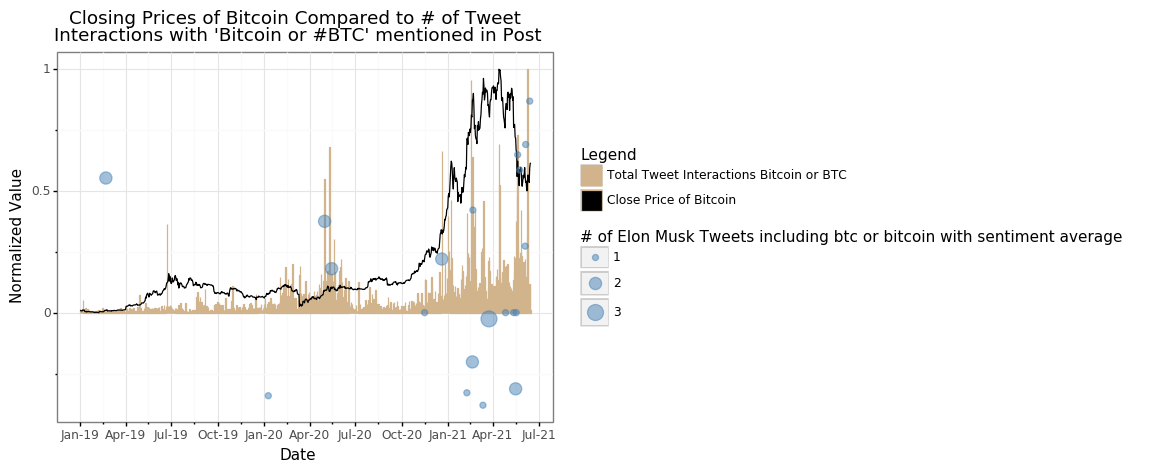

<ggplot: (-9223363252671169820)>

In [43]:
# plot 6
p6 = (ggplot(bitcoin_new,aes(x='Date',group = 1))
 +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'tan'"),color='tan',stat='identity')
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_point(bitcoin_new[bitcoin_new['elon_btc']!=0],aes(y="elon_sentiment_mean",size = 'factor(elon_btc)'),color='steelblue',alpha=0.5)
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet \nInteractions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Normalized Value')
 +scale_fill_identity(guide='legend', labels=['Total Tweet Interactions Bitcoin or BTC','Close Price of Bitcoin'],name='Legend')
 +labs(size = "# of Elon Musk Tweets including btc or bitcoin with sentiment average")
 +theme_bw()
)
p6

In [44]:
# saving images
ggsave(plot = p5, filename = "plot5.jpg",width = 10,height = 10,units = "in")
ggsave(plot= p6, filename = "plot6.jpg",width = 10,height = 10,units = "in")

## Section 2: Summary/Key Findings
[Back to Table of Contents](#Table-of-Contents)

The initial finding of the sentiment analysis is there is a spike with the weighted sentiment of tweets mentioning btc/bitcoin right before the sharp increase in bitcoin stock. Additionally in the visual including elon musk tweets, there is a slight indication that there could be a correlation between when elon musk tweets positively when mentioning bitcoin and the increase in stock prices. Also, when elon tweets negatively when mentioning bitcoin and the decrease in stock prices. This is only shown visually and open for intepretation but intriguing nonetheless.

# ----------------------------End of Section 2----------------------------

# Section 3: Further Analysis/Data Visualization
[Back to Table of Contents](#Table-of-Contents)

## Repeat the same steps from section 1, but using hourly yahoo finance stock data instead of daily stock data

### Load in Data

In [45]:
os.chdir('../../casestudy_data/group_9/')

In [46]:
tweet_hourly = pd.read_csv("cleaned_tweets_and_close_prices_hourly_8months.csv")
yahoo_hourly = pd.read_csv("hourly_stock_last8mo.csv")

In [47]:
# change path back to original directory
os.chdir(path)

In [48]:
tweet_hourly.head()

,Unnamed: 0,content,replyCount,retweetCount,likeCount,quoteCount,lang,keyword_search,username,displayname,...,contains_#dogecoin,contains_#gamestop,no_hashtag,contains_$TSLA,contains_$BTC,contains_$DOGE,contains_$GME,contains_$AMC,no_cashtag,BTC-USD
0,0,@tobyliiiiiiiiii @f_rmnn Cool,526,330,8210,19,en,elonmusk,elonmusk,Elon Musk,...,False,False,True,False,False,False,False,False,True,NaN
1,1,@FOXSports Epic dog,607,504,5163,50,en,elonmusk,elonmusk,Elon Musk,...,False,False,True,False,False,False,False,False,True,NaN
2,2,K is Kindred,12130,1766,34151,244,en,elonmusk,elonmusk,Elon Musk,...,False,False,True,False,False,False,False,False,True,NaN
3,3,Could turn out to be one big Philip K Dick jok...,7433,3281,60077,322,en,elonmusk,elonmusk,Elon Musk,...,False,False,True,False,False,False,False,False,True,NaN
4,4,"Pluto takes 248 years to orbit the sun, but Ur...",14063,12184,197174,1898,en,elonmusk,elonmusk,Elon Musk,...,False,False,True,False,False,False,False,False,True,NaN


In [49]:
yahoo_hourly.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,ticker
0,2020-11-22 21:00:00+00:00,18510.294922,18575.474609,18473.914062,18575.183594,18575.183594,0,BTC-USD
1,2020-11-22 22:00:00+00:00,18575.218750,18610.132812,18505.962891,18606.273438,18606.273438,0,BTC-USD
2,2020-11-22 23:00:00+00:00,18606.335938,18606.335938,18371.343750,18371.343750,18371.343750,205533184,BTC-USD
3,2020-11-23 00:00:00+00:00,18370.017578,18468.765625,18138.376953,18145.677734,18145.677734,0,BTC-USD
4,2020-11-23 01:00:00+00:00,18145.539062,18197.230469,18000.796875,18177.880859,18177.880859,0,BTC-USD


### Data Carpentry - hourly yahoo data

In [50]:
# Change column name to be compatiable with pre-written code
yahoo_hourly = yahoo_hourly.rename(columns={"Unnamed: 0": "Date"})

In [51]:
# subset yahoo data
yahoo_hourly = yahoo_hourly[["Date","Close","Volume","ticker"]]

In [52]:
# only keeping bitcoin ticker
yahoo_hourly = yahoo_hourly[yahoo_hourly['ticker'] == 'BTC-USD']

# sorting values from farthest date to most recent
yahoo_hourly = yahoo_hourly.sort_values('Date',ascending = True)

# resetting index
yahoo_hourly.reset_index(drop=True,inplace=True)

# creating a column that calculates the previous day close
yahoo_hourly['previous_day_close'] = yahoo_hourly.Close.shift()

# creating a feature that identifies if the price went up or down from the previous day's close
yahoo_hourly['target_increase'] = 0
yahoo_hourly.loc[(yahoo_hourly['Close'] - yahoo_hourly['previous_day_close']) > 0, 'target_increase'] = 1

In [53]:
# create column that takes the some of total interactions on a tweet
tweet_hourly['totalCount'] = tweet_hourly['replyCount'] + tweet_hourly['retweetCount']+ tweet_hourly['likeCount'] + tweet_hourly['quoteCount']

In [54]:
# subset twitter dataset
tweet_volumes_hourly = tweet_hourly[['replyCount','retweetCount','likeCount','quoteCount','totalCount','keyword_search','Date']]

# sum relevant like, reply, etc twitter counts by date and keyword
tweet_volumes_hourly = tweet_volumes_hourly.groupby(['Date','keyword_search']).sum().reset_index()

# pivot tweet volumes df
tweet_volumes_hourly = tweet_volumes_hourly.pivot(index='Date', columns='keyword_search',values = ['replyCount','retweetCount','likeCount','quoteCount','totalCount'])

# change from multi-index to single index columns
tweet_volumes_hourly.columns = ['_'.join(col) for col in tweet_volumes_hourly.columns.values]

# reset index
tweet_volumes_hourly = tweet_volumes_hourly.reset_index()

In [55]:
# group by date and keyword search to get number of tweets posted by specific keyword by date
tweetcounts_hourly = tweet_hourly.groupby(['Date','keyword_search']).count()['content']
tweetcounts_hourly = tweetcounts_hourly.reset_index()
tweetcounts_hourly = tweetcounts_hourly.rename({'content':'tweetCount'},axis=1)

# pivot tweet volumes df
tweetcounts_hourly = tweetcounts_hourly.pivot(index='Date', columns='keyword_search',values = 'tweetCount')
tweetcounts_hourly.columns = ['tweetCount_' + col for col in tweetcounts_hourly.columns]

In [56]:
# Reformat Date in Yahoo dataset to match the others
yahoo_hourly["Date"] = pd.DatetimeIndex(pd.to_datetime(yahoo_hourly['Date'], utc=True)).tz_localize(None)
yahoo_hourly["Date"] = yahoo_hourly["Date"].astype(str)

### Combined hourly yahoo data and twitter data

In [57]:
# merge datasets together
base_hourly = yahoo_hourly.merge(tweet_volumes_hourly, left_on='Date',right_on='Date')
base_hourly = base_hourly.merge(tweetcounts_hourly, left_on='Date',right_on='Date')

In [58]:
# convert Date to datetime datatype
base_hourly['Date'] = pd.to_datetime(base_hourly['Date'])

In [59]:
# fill in missing values with 0
base_hourly = base_hourly.fillna(0)

In [60]:
# creating a new dataframe only for bitcoin stock ticker
bitcoin_hourly = base_hourly[base_hourly['ticker']=='BTC-USD']

In [61]:
# Normalize the y-variables so they appear on the same scale
bitcoin_hourly['Close_norm'] = (bitcoin_hourly['Close']-bitcoin_hourly['Close'].min())/(bitcoin_hourly['Close'].max()-bitcoin_hourly['Close'].min())
bitcoin_hourly['totalCount_#BTC_norm'] = (bitcoin_hourly['totalCount_#BTC']-bitcoin_hourly['totalCount_#BTC'].min())/(bitcoin_hourly['totalCount_#BTC'].max()-bitcoin_hourly['totalCount_#BTC'].min())
bitcoin_hourly['totalCount_Bitcoin_norm'] = (bitcoin_hourly['totalCount_Bitcoin']-bitcoin_hourly['totalCount_Bitcoin'].min())/(bitcoin_hourly['totalCount_Bitcoin'].max()-bitcoin_hourly['totalCount_Bitcoin'].min())

# creating a datapoint that combines the total tweet interactions of tweets with #BTC or bitcoin referenced
bitcoin_hourly['totalCount_btc_or_bitcoin'] = bitcoin_hourly['totalCount_#BTC'] + bitcoin_hourly['totalCount_Bitcoin']

bitcoin_hourly['totalCount_btc_or_bitcoin_norm'] = (bitcoin_hourly['totalCount_btc_or_bitcoin']-bitcoin_hourly['totalCount_btc_or_bitcoin'].min())/(bitcoin_hourly['totalCount_btc_or_bitcoin'].max()-bitcoin_hourly['totalCount_btc_or_bitcoin'].min())

bitcoin_hourly['replyCount_elonmusk_norm'] = (bitcoin_hourly['replyCount_elonmusk']-bitcoin_hourly['replyCount_elonmusk'].min())/(bitcoin_hourly['replyCount_elonmusk'].max()-bitcoin_hourly['replyCount_elonmusk'].min())

##  Plots below: Using HOURLY yahoo finance dataset

In [62]:
# plot 1, but using hourly data from last 8 months
p1_hourly = (ggplot(bitcoin_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_#BTC_norm',fill="'steelblue'"),color='steelblue',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compare to # of Tweet Interactions with '#BTC' Mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close', 'Tweet Interactions #BTC'],name='Legend')
 +theme_bw()
)


In [63]:
# plot 2, using hourly data
p2_hourly = (ggplot(bitcoin_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_Bitcoin_norm',fill="'darkgreen'"),color='darkgreen',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close', 'Tweet Interactions Bitcoin'],name='Legend')
 +theme_bw()
)

In [64]:
# saving images
ggsave(plot = p1_hourly, filename = "plot1_hourly.jpg",width = 10,height = 10,units = "in")
ggsave(plot= p2_hourly, filename = "plot2_hourly.jpg",width = 10,height = 10,units = "in")

In [65]:
# opening images as plots
img_hourly = Image.open("plot1_hourly.jpg")
img2_hourly = Image.open("plot2_hourly.jpg")

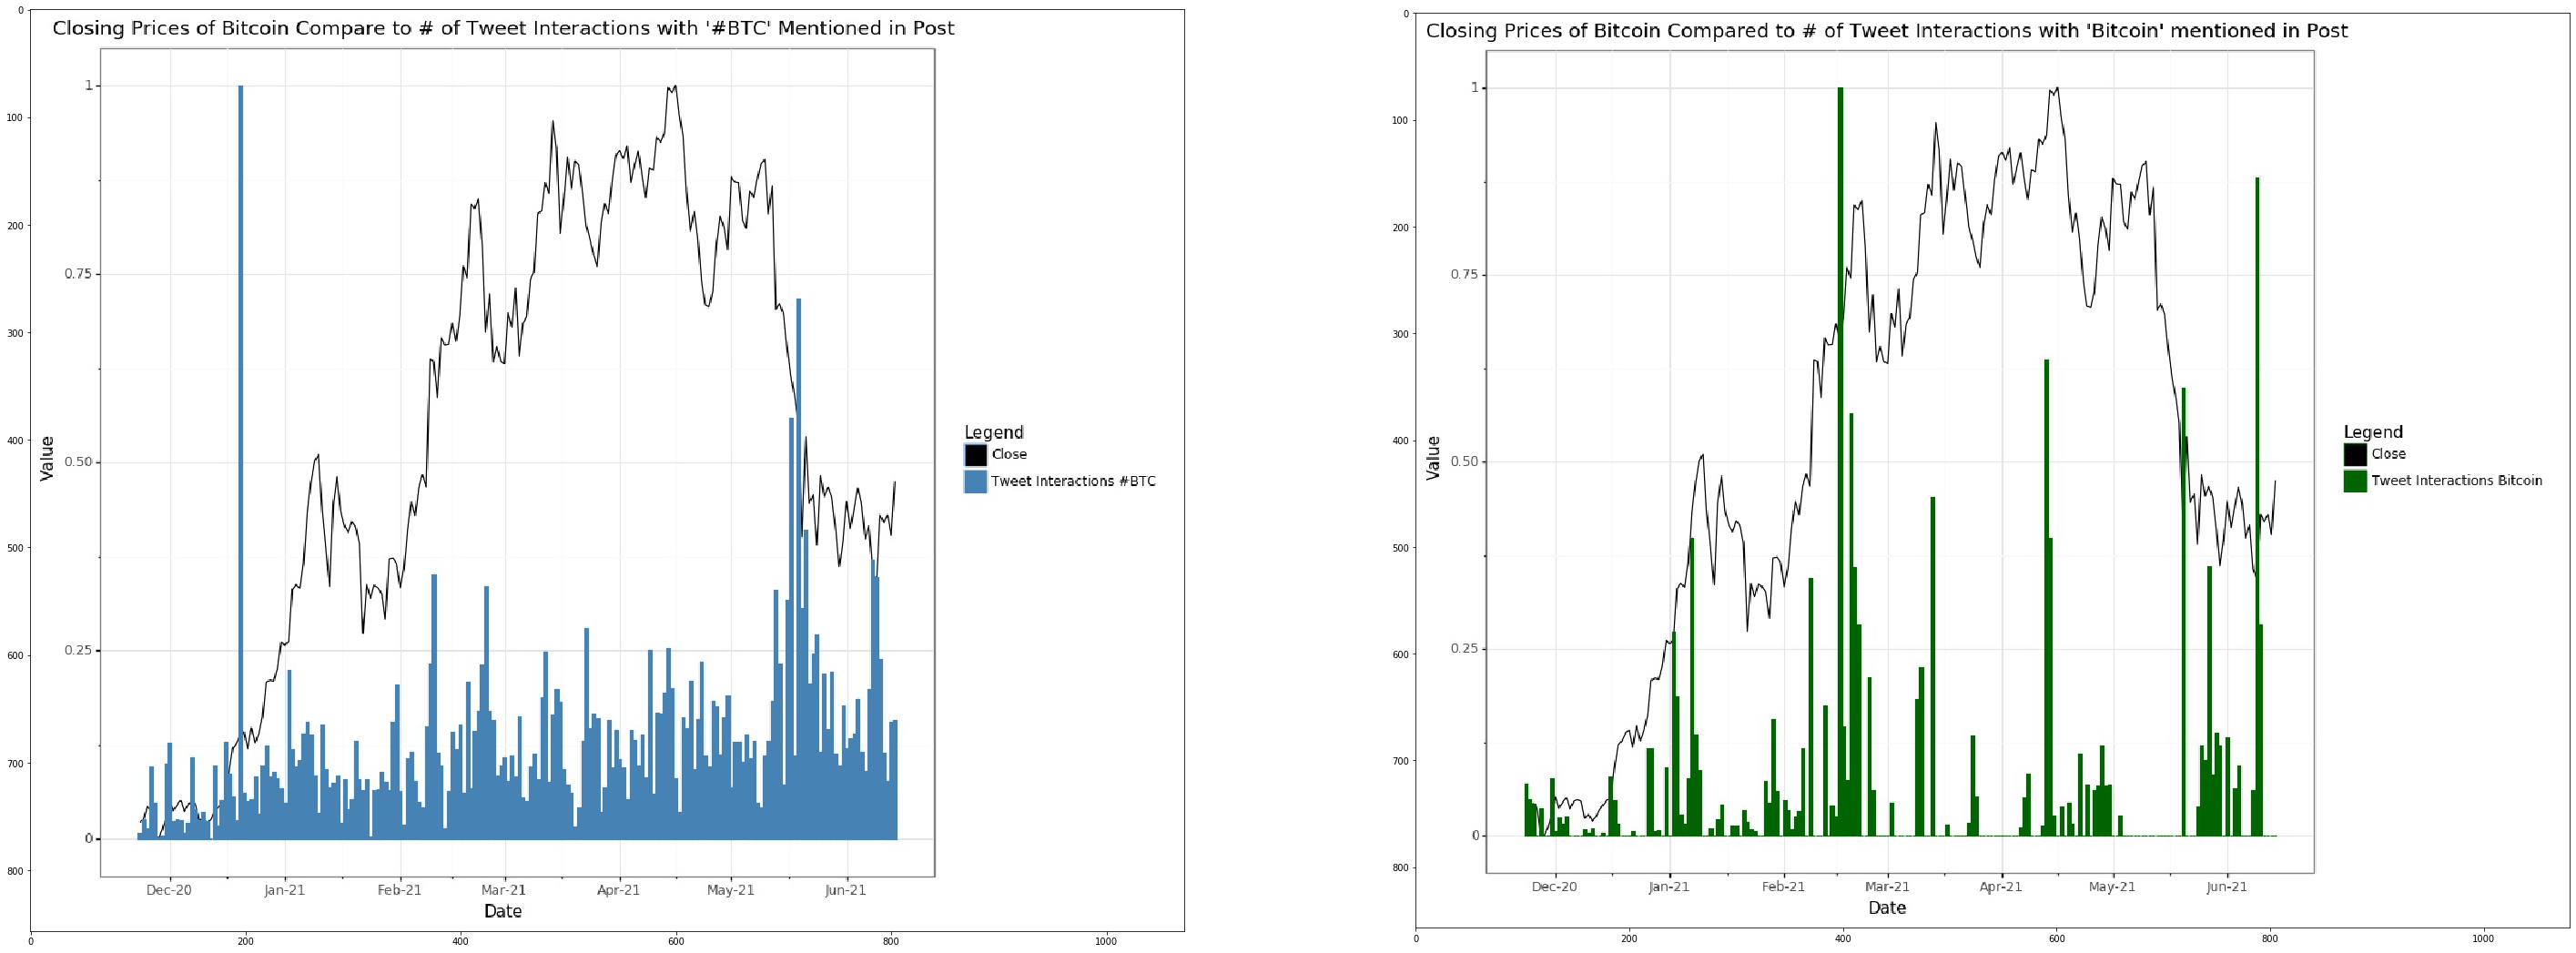

In [66]:
# comparing plot images for a side by side comparison
fig = plt.gcf()
fig.set_size_inches(50, 50)
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_hourly)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img2_hourly)


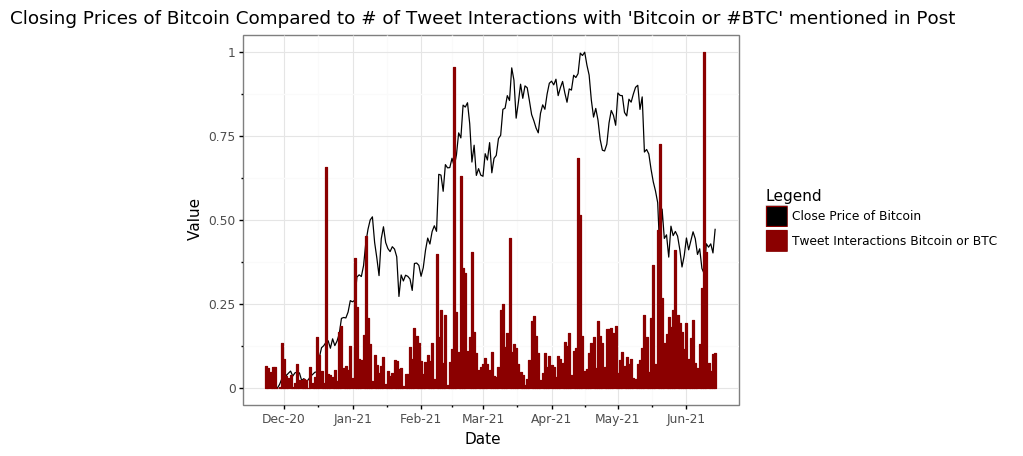

<ggplot: (-9223363252639987452)>

In [67]:
# plot 3 hourly
p3_hourly = (ggplot(bitcoin_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'darkred'"),color='darkred',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close Price of Bitcoin', 'Tweet Interactions Bitcoin or BTC'],name='Legend')
 +theme_bw()
)
p3_hourly

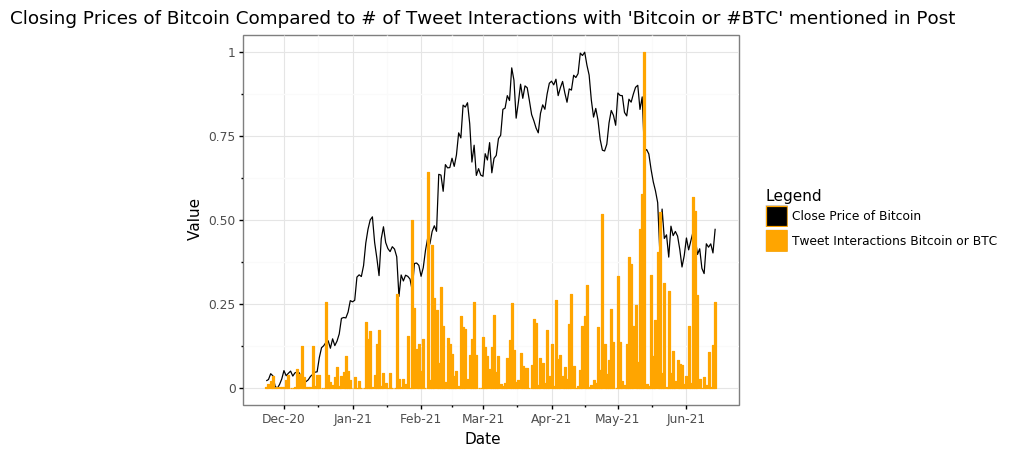

<ggplot: (-9223363252548451591)>

In [68]:
# plot 4 hourly
p4_hourly = (ggplot(bitcoin_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='replyCount_elonmusk_norm',fill="'orange'"),color='orange',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close Price of Bitcoin', 'Tweet Interactions Bitcoin or BTC'],name='Legend')
 +theme_bw()
)
p4_hourly

## Create daily and hourly twitter datasets with bots removed

**Look at the top 100 users and manually remove the ones that are definitely or probably bots**. This was somewhat subjective, but most bots are obvious to the human eye. Their usernames are often giveaways, such as whale_alert. This is a bot that alerts its followers when a "whale", someone with a large amount of bitcoin, makes a large transaction with bitcoin. Users that tweet 24/7 are also more likely to be bots, since humans sleep. Users that tweet constantly or post dozens of tweets in just a few minutes are often bots. Users whose number of tweets/number of followers ratio is far higher than average, meaning some bots have 10s of thousands of tweets and only dozens or hundreds of followers. After going through the top 100 users manually and taking out the users who were obviously bots, we tried to automate the process using what we learned from the manual bot removal. We found a number of keywords that were found almost exclusively in bots' usernames, so we removed all tweets from users whose usernames contained the keywords.

In [69]:
# Number of unique users
len(tweet['username'].unique())

87151

In [70]:
# Usernames of 100 most frequent tweeters
n = 100
tweet['username'].value_counts()[:n].index.tolist()

['ClankApp',
 'APompliano',
 'ChainDotInfo',
 'AMCTheatres',
 'BillyM2k',
 'webnowcompany',
 'whale_alert',
 'elonmusk',
 '2Strawberries_',
 'GameStop',
 'TradeStrategyCo',
 'AriumCrypto',
 'CoinoMonitor',
 'vinmaxinfotech',
 'BlockScan',
 'MempoolWhales',
 'CryptoBert1',
 'mcuban',
 'binance_jp_20p',
 'stipsoculus',
 'zloadr',
 'Bitcoin',
 'xbtmoney',
 'PhoenixSquawk',
 'OneCryptoCap1',
 'Crypto__Blocks',
 'SpaceX',
 'DYORCryptoBot',
 'WhaleAler',
 'BalanceOt',
 'CryptoBitsNews1',
 'MustHaveCrypto',
 'AlphaexCapital',
 'adctrader',
 'ValerySobolev',
 'bitcoinmate',
 'intotheblock',
 'cryptomike2k',
 'Tesla',
 'DomainAddress4u',
 '22_cryptohelp',
 'thecryptokeepr',
 'scalperSignals',
 'Alla92490007',
 'UniswapUnicorns',
 'Whale_Alerts',
 'CryptoTxAlerts',
 'EarlyAdopter23',
 'TheBitcoinNews',
 'ELEMoneymaker',
 'WiseAnalyze',
 'nozzybozzy',
 'AlertTrade',
 'Martin68072602',
 'CryptoWolfPack',
 'kushjain11',
 'DR6am',
 'jsvisa',
 'bitoco_in',
 'CryptoCurrNews',
 'doge4you',
 'bitcoinagi

### Patterns that indicate a user is a bot: 
1. Username contains the words "alert", "whales", "news", "signals", "bot", "app", "project", or "site"
2. User tweets frequently all hours of the day, or more than a few times an hour
3. All posts are links to articles, use the same format, or are retweets
4. User never replies to other users' tweets
5. Very high tweet/follower ratio

In [71]:
# Manually remove the users above that are bots
tweet_no_bots = tweet[(tweet['username'] != 'ClankApp')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'ChainDotInfo')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'webnowcompany')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'whale_alert')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != '2Strawberries_')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'TradeStrategyCo')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'AriumCrypto')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CoinoMonitor')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'BlockScan')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'MempoolWhales')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CryptoBert1')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'binance_jp_20p')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'zloadr')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'OneCryptoCap1')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'Crypto__Blocks')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'DYORCryptoBot')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'WhaleAler')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'BalanceOt')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CryptoBitsNews1')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'MustHaveCrypto')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'AlphaexCapital')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'adctrader')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'bitcoinmate')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'ValerySobolev')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'cryptomike2k')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'DomainAddress4u')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != '22_cryptohelp')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'scalperSignals')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'Alla92490007')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'Whale_Alerts')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CryptoTxAlerts')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'TheBitcoinNews')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'ELEMoneymaker')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'AlertTrade')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CryptoWolfPack')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'jsvisa')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'bitoco_in')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CryptoCurrNews')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'doge4you')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'bitcoinagile')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CMC_Site')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'coinspectator')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'rektcapital')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'thuthuatmaytinh')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'usd2btc')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'SergheiPogor')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CurrencyTimes')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'smd_success')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'MoneroWith')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'LearnToTradeFX_')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'GetTheCrypto1')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'mbet_io')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'ReplayCrypto')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'bitstreetbets')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'og_dogecoin')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'AlertBitcoin')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != '_Crypto_papa')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CashTechNews')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'binance__id____')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'AlgoryProject')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'smart_stats')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'optionsproalert')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'CryptoNews_Ex')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'DogeWhales')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'thecapital_io')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'executium')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'churi_mon')]
tweet_no_bots = tweet_no_bots[(tweet_no_bots['username'] != 'altcoingazette')]

In [72]:
# tweet dataframe before bot removal (rows x columns)
tweet.shape

(446686, 44)

In [73]:
# tweet dataframe after bot removal (rows x columns)
tweet_no_bots.shape

(320315, 44)

In [74]:
# Manually removing the most prolific bots significantly shrinks the dataset
# Also remove users with terms "alert", "whale", "news", "signal", "bot", or "app"
# in the username or description, because they are almost certainly bots and the removal is relatively easy to automate
tweet_no_bots = tweet_no_bots[tweet_no_bots["username"].str.lower().str.contains("alert")==False]
tweet_no_bots = tweet_no_bots[tweet_no_bots["username"].str.lower().str.contains("whale")==False]
tweet_no_bots = tweet_no_bots[tweet_no_bots["username"].str.lower().str.contains("news")==False]
tweet_no_bots = tweet_no_bots[tweet_no_bots["username"].str.lower().str.contains("signal")==False]
tweet_no_bots = tweet_no_bots[tweet_no_bots["username"].str.lower().str.contains("bot")==False]
tweet_no_bots = tweet_no_bots[tweet_no_bots["username"].str.lower().str.contains("app")==False]

In [75]:
tweet_no_bots.shape

(315574, 44)

### To summarize, the top 100 most prolific users' tweets who were most likely bots were manually removed. Bots who could be easily automatically filtered were also removed from the dataset.

**Now do the same with the hourly data**

In [76]:
# Manually remove the same top bots as before
tweet_no_bots_hourly = tweet_hourly[(tweet_hourly['username'] != 'ClankApp')]

tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'ChainDotInfo')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'webnowcompany')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'whale_alert')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != '2Strawberries_')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'TradeStrategyCo')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'AriumCrypto')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CoinoMonitor')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'BlockScan')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'MempoolWhales')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CryptoBert1')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'binance_jp_20p')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'zloadr')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'OneCryptoCap1')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'Crypto__Blocks')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'DYORCryptoBot')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'WhaleAler')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'BalanceOt')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CryptoBitsNews1')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'MustHaveCrypto')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'AlphaexCapital')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'adctrader')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'bitcoinmate')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'ValerySobolev')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'cryptomike2k')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'DomainAddress4u')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != '22_cryptohelp')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'scalperSignals')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'Alla92490007')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'Whale_Alerts')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CryptoTxAlerts')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'TheBitcoinNews')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'ELEMoneymaker')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'AlertTrade')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CryptoWolfPack')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'jsvisa')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'bitoco_in')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CryptoCurrNews')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'doge4you')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'bitcoinagile')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CMC_Site')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'coinspectator')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'rektcapital')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'thuthuatmaytinh')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'usd2btc')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'SergheiPogor')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CurrencyTimes')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'smd_success')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'MoneroWith')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'LearnToTradeFX_')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'GetTheCrypto1')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'mbet_io')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'ReplayCrypto')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'bitstreetbets')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'og_dogecoin')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'AlertBitcoin')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != '_Crypto_papa')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CashTechNews')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'binance__id____')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'AlgoryProject')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'smart_stats')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'optionsproalert')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'CryptoNews_Ex')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'DogeWhales')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'thecapital_io')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'executium')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'churi_mon')]
tweet_no_bots_hourly = tweet_no_bots_hourly[(tweet_no_bots_hourly['username'] != 'altcoingazette')]

In [77]:
tweet_no_bots_hourly = tweet_no_bots_hourly[tweet_no_bots_hourly["username"].str.lower().str.contains("alert")==False]
tweet_no_bots_hourly = tweet_no_bots_hourly[tweet_no_bots_hourly["username"].str.lower().str.contains("whale")==False]
tweet_no_bots_hourly = tweet_no_bots_hourly[tweet_no_bots_hourly["username"].str.lower().str.contains("news")==False]
tweet_no_bots_hourly = tweet_no_bots_hourly[tweet_no_bots_hourly["username"].str.lower().str.contains("signal")==False]
tweet_no_bots_hourly = tweet_no_bots_hourly[tweet_no_bots_hourly["username"].str.lower().str.contains("bot")==False]
tweet_no_bots_hourly = tweet_no_bots_hourly[tweet_no_bots_hourly["username"].str.lower().str.contains("app")==False]

In [78]:
tweet_hourly.shape

(239709, 45)

In [79]:
tweet_no_bots_hourly.shape

(179719, 45)

## Comparing data with bots removed to data with bots not removed

### Reformat tweet_no_bots and tweet_no_bots_hourly in order to do the same visualizations as above and to perform cross-correlation analysis. This is essentially just part 1 copy/pasted.

**Daily data with no bots**

In [80]:
# Repeat the same steps from above to make visualizations for datasets with no bots

# change path variables
os.chdir('../../casestudy_data/group_9/')

yahoo_no_bots = pd.read_csv("daily_stock_last5yr.csv")

# change path back to original directory
os.chdir(path)

In [81]:
# subset yahoo data
yahoo_no_bots = yahoo_no_bots[["Date","Close","Volume","ticker"]]

# only keeping bitcoin ticker
yahoo_no_bots = yahoo_no_bots[yahoo_no_bots['ticker'] == 'BTC-USD']

# sorting values from farthest date to most recent
yahoo_no_bots = yahoo_no_bots.sort_values('Date',ascending = True)

# resetting index
yahoo_no_bots.reset_index(drop=True,inplace=True)

# creating a column that calculates the previous day close
yahoo_no_bots['previous_day_close'] = yahoo_no_bots.Close.shift()

# creating a feature that identifies if the price went up or down from the previous day's close
yahoo_no_bots['target_increase'] = 0
yahoo_no_bots.loc[(yahoo_no_bots['Close'] - yahoo_no_bots['previous_day_close']) > 0, 'target_increase'] = 1

In [82]:
# convert datatypes to dates
yahoo_no_bots['Date'] = pd.to_datetime(yahoo['Date'])
tweet_no_bots['Date'] = pd.to_datetime(tweet['Date'])

In [83]:
# create column that takes the some of total interactions on a tweet
tweet_no_bots['totalCount'] = tweet_no_bots['replyCount'] + tweet_no_bots['retweetCount']
+ tweet_no_bots['likeCount'] + tweet_no_bots['quoteCount']

# subset twitter dataset
tweet_volumes_no_bots = tweet_no_bots[['replyCount','retweetCount','likeCount','quoteCount','totalCount','keyword_search','Date']]

# sum relevant like, reply, etc twitter counts by date and keyword
tweet_volumes_no_bots = tweet_volumes_no_bots.groupby(['Date','keyword_search']).sum().reset_index()

# pivot tweet volumes df
tweet_volumes_no_bots = tweet_volumes_no_bots.pivot(index='Date', columns='keyword_search',values = ['replyCount','retweetCount','likeCount','quoteCount','totalCount'])

# change from multi-index to single index columns
tweet_volumes_no_bots.columns = ['_'.join(col) for col in tweet_volumes_no_bots.columns.values]

# reset index
tweet_volumes_no_bots = tweet_volumes_no_bots.reset_index()

# group by date and keyword search to get number of tweets posted by specific keyword by date
tweetcounts_no_bots = tweet_no_bots.groupby(['Date','keyword_search']).count()['content']
tweetcounts_no_bots = tweetcounts_no_bots.reset_index()
tweetcounts_no_bots = tweetcounts_no_bots.rename({'content':'tweetCount'},axis=1)

# pivot tweet volumes df
tweetcounts_no_bots = tweetcounts_no_bots.pivot(index='Date', columns='keyword_search',values = 'tweetCount')
tweetcounts_no_bots.columns = ['tweetCount_' + col for col in tweetcounts_no_bots.columns]

# Reformat Date in Yahoo dataset to match the others
#yahoo_no_bots["Date"] = pd.DatetimeIndex(pd.to_datetime(yahoo_no_bots['Date'], utc=True)).tz_localize(None)
#yahoo_no_bots["Date"] = yahoo_no_bots["Date"].astype(str)

# merge datasets together
base_no_bots = yahoo_no_bots.merge(tweet_volumes_no_bots, left_on='Date',right_on='Date')
base_no_bots = base_no_bots.merge(tweetcounts_no_bots, left_on='Date',right_on='Date')

# convert Date to datetime datatype
base_no_bots['Date'] = pd.to_datetime(base_no_bots['Date'])

# fill in missing values with 0
base_no_bots = base_no_bots.fillna(0)

# creating a new dataframe only for bitcoin stock ticker
bitcoin_no_bots = base_no_bots[base_no_bots['ticker']=='BTC-USD']

# Normalize the y-variables so they appear on the same scale
bitcoin_no_bots['Close_norm'] = (bitcoin_no_bots['Close']-bitcoin_no_bots['Close'].min())/(bitcoin_no_bots['Close'].max()-bitcoin_no_bots['Close'].min())
bitcoin_no_bots['totalCount_#BTC_norm'] = (bitcoin_no_bots['totalCount_#BTC']-bitcoin_no_bots['totalCount_#BTC'].min())/(bitcoin_no_bots['totalCount_#BTC'].max()-bitcoin_no_bots['totalCount_#BTC'].min())
bitcoin_no_bots['totalCount_Bitcoin_norm'] = (bitcoin_no_bots['totalCount_Bitcoin']-bitcoin_no_bots['totalCount_Bitcoin'].min())/(bitcoin_no_bots['totalCount_Bitcoin'].max()-bitcoin_no_bots['totalCount_Bitcoin'].min())

In [84]:
# creating a datapoint that combines the total tweet interactions of tweets with #BTC or bitcoin referenced
bitcoin_no_bots['totalCount_btc_or_bitcoin'] = bitcoin_no_bots['totalCount_#BTC'] + bitcoin_no_bots['totalCount_Bitcoin']

bitcoin_no_bots['totalCount_btc_or_bitcoin_norm'] = (bitcoin_no_bots['totalCount_btc_or_bitcoin']-bitcoin_no_bots['totalCount_btc_or_bitcoin'].min())/(bitcoin_no_bots['totalCount_btc_or_bitcoin'].max()-bitcoin_no_bots['totalCount_btc_or_bitcoin'].min())

In [85]:
bitcoin_no_bots['replyCount_elonmusk_norm'] = (bitcoin_no_bots['replyCount_elonmusk']-bitcoin_no_bots['replyCount_elonmusk'].min())/(bitcoin_no_bots['replyCount_elonmusk'].max()-bitcoin_no_bots['replyCount_elonmusk'].min())

## Plots below: removing bots and using DAILY yahoo finance dataset

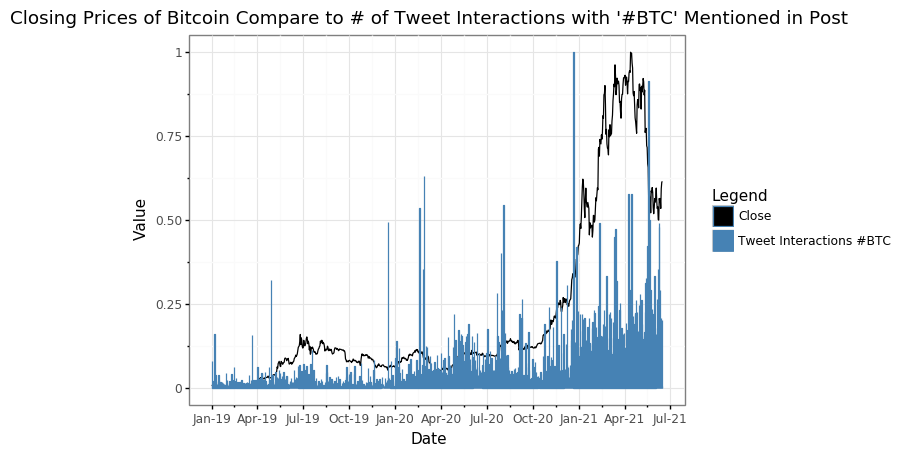

<ggplot: (-9223363252532174357)>

In [86]:
# plot 1, but using daily stock data- removed bots manually
p1_no_bots = (ggplot(bitcoin_no_bots,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_#BTC_norm',fill="'steelblue'"),color='steelblue',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compare to # of Tweet Interactions with '#BTC' Mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close', 'Tweet Interactions #BTC'],name='Legend')
 +theme_bw()
)
p1_no_bots

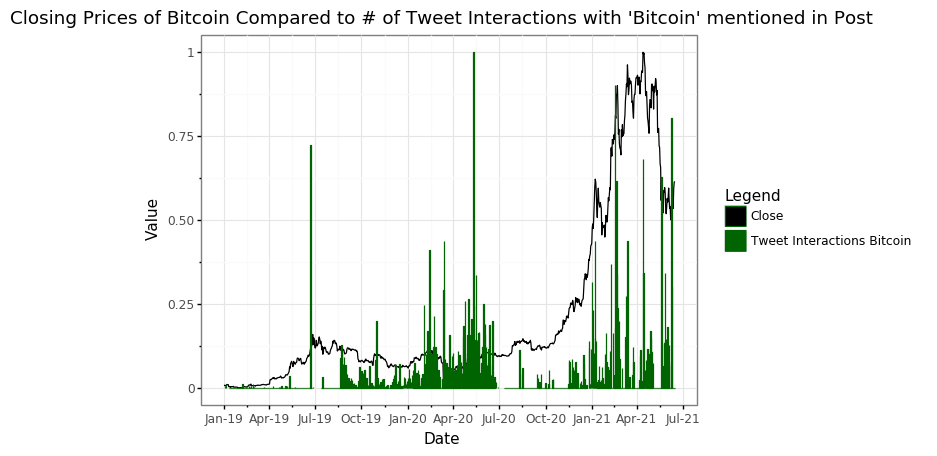

<ggplot: (8784208732641)>

In [87]:
# plot 2, but using daily stock data- removed bots manually
p2_no_bots = (ggplot(bitcoin_no_bots,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_Bitcoin_norm',fill="'darkgreen'"),color='darkgreen',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close', 'Tweet Interactions Bitcoin'],name='Legend')
 +theme_bw()
)
p2_no_bots

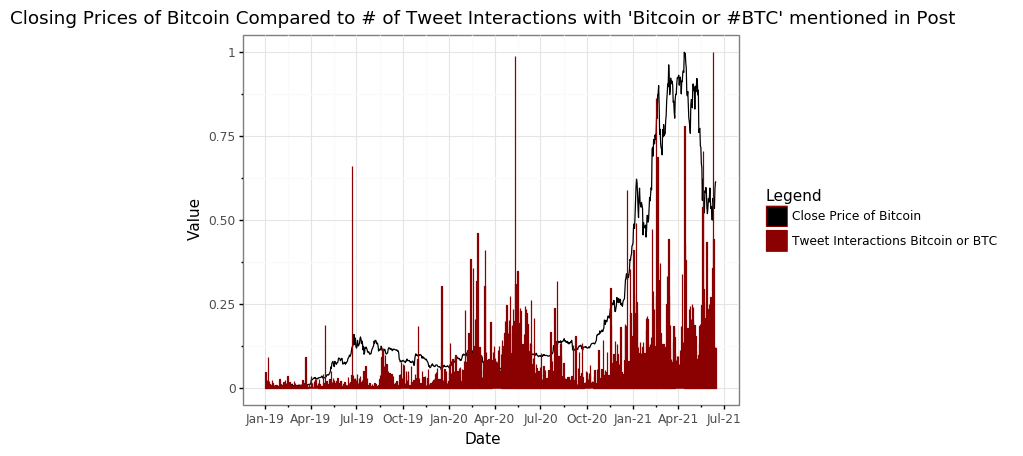

<ggplot: (8784209579307)>

In [88]:
# plot 3, but using daily stock data- removed bots manually
p3_no_bots = (ggplot(bitcoin_no_bots,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'darkred'"),color='darkred',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close Price of Bitcoin', 'Tweet Interactions Bitcoin or BTC'],name='Legend')
 +theme_bw()
)
p3_no_bots

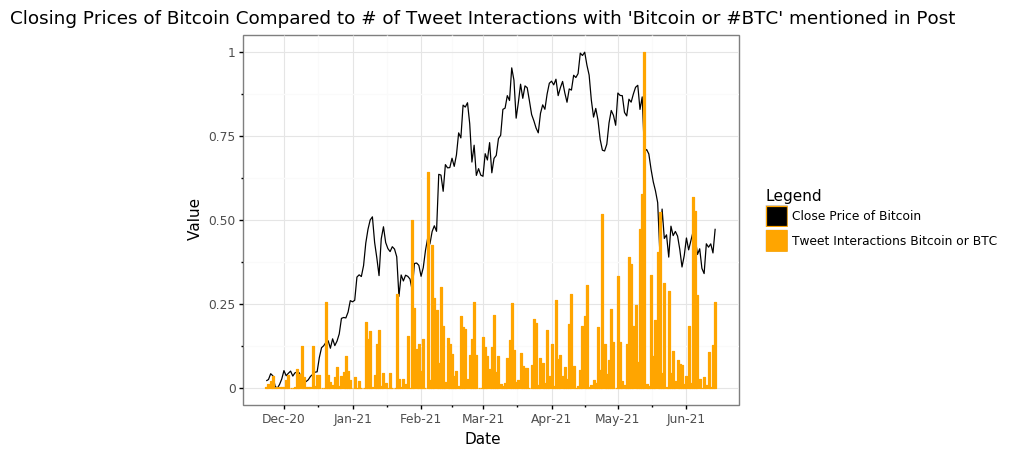

<ggplot: (-9223363252548451591)>

In [89]:
# plot 4, but using daily stock data- removed bots manually
p4_no_bots = (ggplot(bitcoin_no_bots,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='replyCount_elonmusk_norm',fill="'orange'"),color='orange',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close Price of Bitcoin', 'Tweet Interactions Bitcoin or BTC'],name='Legend')
 +theme_bw()
)
p4_hourly

## Plots below: removing bots and using HOURLY yahoo finance dataset

### Data Carpentry for removing bots from hourly yahoo dataset

In [90]:
# Repeat the same steps above to make visualizations for datasets with no bots

os.chdir('../../casestudy_data/group_9/')

yahoo_no_bots_hourly = pd.read_csv("hourly_stock_last8mo.csv")

# change path back to original directory
os.chdir(path)

# Change column name to be compatiable with pre-written code
yahoo_no_bots_hourly = yahoo_no_bots_hourly.rename(columns={"Unnamed: 0": "Date"})

# subset yahoo data
yahoo_no_bots_hourly = yahoo_no_bots_hourly[["Date","Close","Volume","ticker"]]

# only keeping bitcoin ticker
yahoo_no_bots_hourly = yahoo_no_bots_hourly[yahoo_no_bots_hourly['ticker'] == 'BTC-USD']

# sorting values from farthest date to most recent
yahoo_no_bots_hourly = yahoo_no_bots_hourly.sort_values('Date',ascending = True)

# resetting index
yahoo_no_bots_hourly.reset_index(drop=True,inplace=True)

# creating a column that calculates the previous day close
yahoo_no_bots_hourly['previous_day_close'] = yahoo_no_bots_hourly.Close.shift()

# creating a feature that identifies if the price went up or down from the previous day's close
yahoo_no_bots_hourly['target_increase'] = 0
yahoo_no_bots_hourly.loc[(yahoo_no_bots_hourly['Close'] - yahoo_no_bots_hourly['previous_day_close']) > 0, 'target_increase'] = 1

# create column that takes the some of total interactions on a tweet
tweet_no_bots_hourly['totalCount'] = tweet_no_bots_hourly['replyCount'] + tweet_no_bots_hourly['retweetCount']
+ tweet_no_bots_hourly['likeCount'] + tweet_no_bots_hourly['quoteCount']

# subset twitter dataset
tweet_volumes_no_bots_hourly = tweet_no_bots_hourly[['replyCount','retweetCount','likeCount','quoteCount','totalCount','keyword_search','Date']]

# sum relevant like, reply, etc twitter counts by date and keyword
tweet_volumes_no_bots_hourly = tweet_volumes_no_bots_hourly.groupby(['Date','keyword_search']).sum().reset_index()

# pivot tweet volumes df
tweet_volumes_no_bots_hourly = tweet_volumes_no_bots_hourly.pivot(index='Date', columns='keyword_search',values = ['replyCount','retweetCount','likeCount','quoteCount','totalCount'])

# change from multi-index to single index columns
tweet_volumes_no_bots_hourly.columns = ['_'.join(col) for col in tweet_volumes_no_bots_hourly.columns.values]

# reset index
tweet_volumes_no_bots_hourly = tweet_volumes_no_bots_hourly.reset_index()

# group by date and keyword search to get number of tweets posted by specific keyword by date
tweetcounts_no_bots_hourly = tweet_no_bots_hourly.groupby(['Date','keyword_search']).count()['content']
tweetcounts_no_bots_hourly = tweetcounts_no_bots_hourly.reset_index()
tweetcounts_no_bots_hourly = tweetcounts_no_bots_hourly.rename({'content':'tweetCount'},axis=1)

# pivot tweet volumes df
tweetcounts_no_bots_hourly = tweetcounts_no_bots_hourly.pivot(index='Date', columns='keyword_search',values = 'tweetCount')
tweetcounts_no_bots_hourly.columns = ['tweetCount_' + col for col in tweetcounts_no_bots_hourly.columns]

# Reformat Date in Yahoo dataset to match the others
yahoo_no_bots_hourly["Date"] = pd.DatetimeIndex(pd.to_datetime(yahoo_no_bots_hourly['Date'], utc=True)).tz_localize(None)
yahoo_no_bots_hourly["Date"] = yahoo_no_bots_hourly["Date"].astype(str)

# merge datasets together
base_no_bots_hourly = yahoo_no_bots_hourly.merge(tweet_volumes_no_bots_hourly, left_on='Date',right_on='Date')
base_no_bots_hourly = base_no_bots_hourly.merge(tweetcounts_no_bots_hourly, left_on='Date',right_on='Date')

# convert Date to datetime datatype
base_no_bots_hourly['Date'] = pd.to_datetime(base_no_bots_hourly['Date'])

# fill in missing values with 0
base_no_bots_hourly = base_no_bots_hourly.fillna(0)

# creating a new dataframe only for bitcoin stock ticker
bitcoin_no_bots_hourly = base_no_bots_hourly[base_no_bots_hourly['ticker']=='BTC-USD']

# Normalize the y-variables so they appear on the same scale
bitcoin_no_bots_hourly['Close_norm'] = (bitcoin_no_bots_hourly['Close']-bitcoin_no_bots_hourly['Close'].min())/(bitcoin_no_bots_hourly['Close'].max()-bitcoin_no_bots_hourly['Close'].min())
bitcoin_no_bots_hourly['totalCount_#BTC_norm'] = (bitcoin_no_bots_hourly['totalCount_#BTC']-bitcoin_no_bots_hourly['totalCount_#BTC'].min())/(bitcoin_no_bots_hourly['totalCount_#BTC'].max()-bitcoin_no_bots_hourly['totalCount_#BTC'].min())
bitcoin_no_bots_hourly['totalCount_Bitcoin_norm'] = (bitcoin_no_bots_hourly['totalCount_Bitcoin']-bitcoin_no_bots_hourly['totalCount_Bitcoin'].min())/(bitcoin_no_bots_hourly['totalCount_Bitcoin'].max()-bitcoin_no_bots_hourly['totalCount_Bitcoin'].min())

In [91]:
# creating a datapoint that combines the total tweet interactions of tweets with #BTC or bitcoin referenced
bitcoin_no_bots_hourly['totalCount_btc_or_bitcoin'] = bitcoin_no_bots_hourly['totalCount_#BTC'] + bitcoin_no_bots_hourly['totalCount_Bitcoin']
bitcoin_no_bots_hourly['totalCount_btc_or_bitcoin_norm'] = (bitcoin_no_bots_hourly['totalCount_btc_or_bitcoin']-bitcoin_no_bots_hourly['totalCount_btc_or_bitcoin'].min())/(bitcoin_no_bots_hourly['totalCount_btc_or_bitcoin'].max()-bitcoin_no_bots_hourly['totalCount_btc_or_bitcoin'].min())

In [92]:
bitcoin_no_bots_hourly['replyCount_elonmusk_norm'] = (bitcoin_no_bots_hourly['replyCount_elonmusk']-bitcoin_no_bots_hourly['replyCount_elonmusk'].min())/(bitcoin_no_bots_hourly['replyCount_elonmusk'].max()-bitcoin_no_bots_hourly['replyCount_elonmusk'].min())

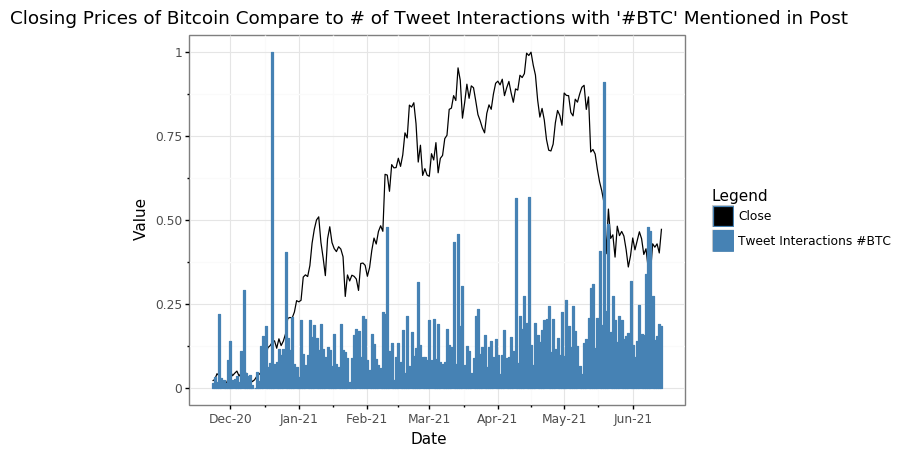

<ggplot: (8784208139177)>

In [93]:
# plot 1, but using hourly data from last 8 months - removing bots manually
p1_no_bots_hourly = (ggplot(bitcoin_no_bots_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_#BTC_norm',fill="'steelblue'"),color='steelblue',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compare to # of Tweet Interactions with '#BTC' Mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close', 'Tweet Interactions #BTC'],name='Legend')
 +theme_bw()
)
p1_no_bots_hourly

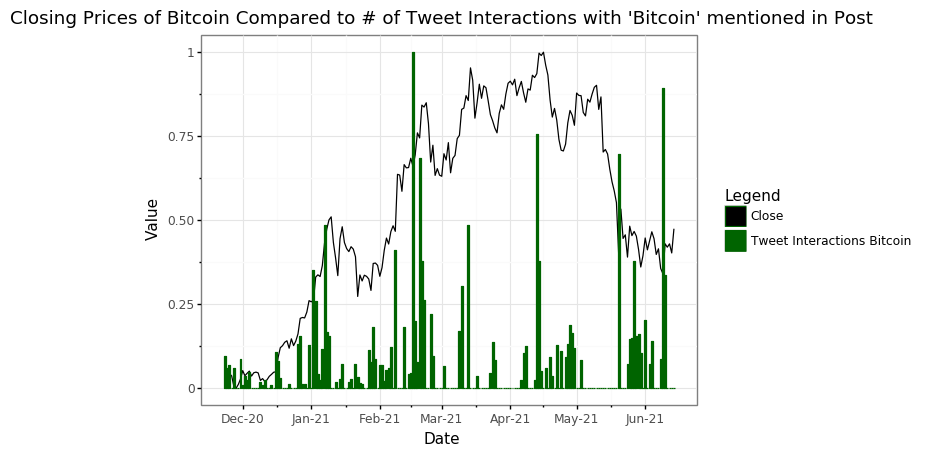

<ggplot: (-9223363252648025642)>

In [94]:
# plot 2, but using hourly data from last 8 months - removing bots manually
p2_no_bots_hourly = (ggplot(bitcoin_no_bots_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_Bitcoin_norm',fill="'darkgreen'"),color='darkgreen',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close', 'Tweet Interactions Bitcoin'],name='Legend')
 +theme_bw()
)
p2_no_bots_hourly

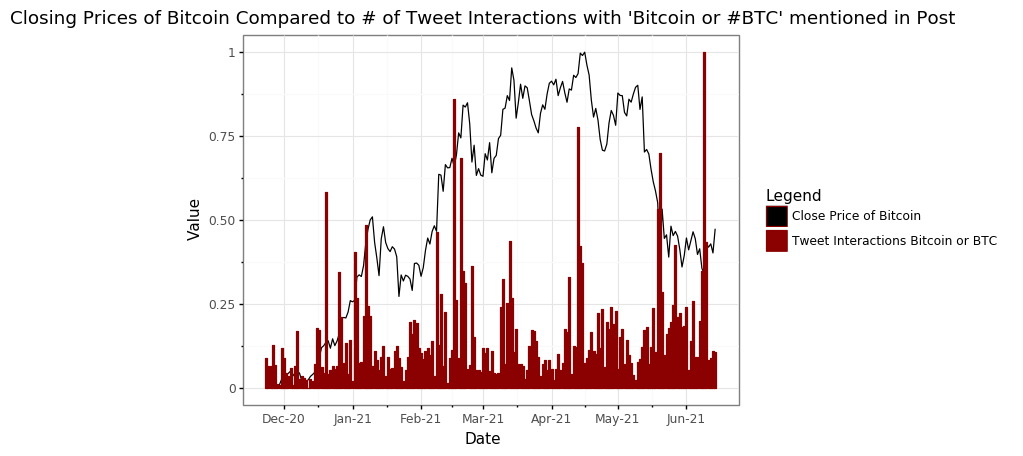

<ggplot: (-9223363252652930777)>

In [95]:
# plot 3, but using hourly data from last 8 months - removing bots manually
p3_no_bots_hourly = (ggplot(bitcoin_no_bots_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'darkred'"),color='darkred',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close Price of Bitcoin', 'Tweet Interactions Bitcoin or BTC'],name='Legend')
 +theme_bw()
)
p3_no_bots_hourly

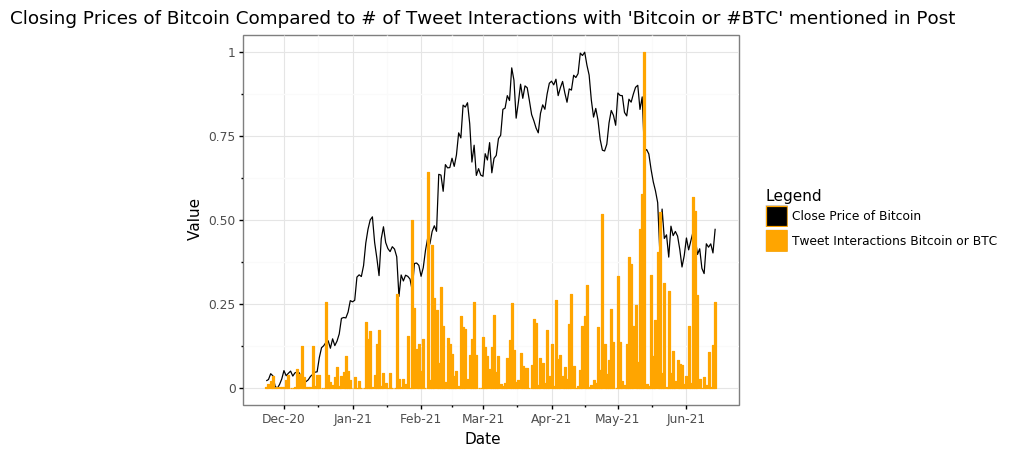

<ggplot: (-9223363252653987100)>

In [96]:
# plot 4, but using hourly data from last 8 months - removing bots manually
p4_no_bots_hourly = (ggplot(bitcoin_no_bots_hourly,aes(x='Date',group = 1))
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_bar(aes(y='replyCount_elonmusk_norm',fill="'orange'"),color='orange',stat='identity')
 +ggtitle("Closing Prices of Bitcoin Compared to # of Tweet Interactions with 'Bitcoin or #BTC' mentioned in Post")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Value')
 +scale_fill_identity(guide='legend', labels=['Close Price of Bitcoin', 'Tweet Interactions Bitcoin or BTC'],name='Legend')
 +theme_bw()
)
p4_no_bots_hourly

## Section 3: Summary/Key Findings
[Back to Table of Contents](#Table-of-Contents)

Removing bots from the datasets show even larger spikes of total interactions with tweets mentioning bitcoin/btw prior to the increase in bitcoin prices. Additionally while not completely clear, there appears to be a similar increase and decrease of tweet interactions to the increase and decrease of closing price of bitcoin when viewed at an hourly level and a smaller timeframe (last 8 months). This isn't noticeable across every single small increase/decrease bue with large jumps in stock price there appears to be more interactions in tweets.

# ----------------------------End of Section 3----------------------------

# Section 4: Final Visualizations Used in Data Story
[Back to Table of Contents](#Table-of-Contents)

### Overview: 

The following visualizations are what we ended up using in the data story. They are improvements upon the previous visualizations that add a little bit more information and have what we believe is a better color scheme.

## Daily Visual included in data story

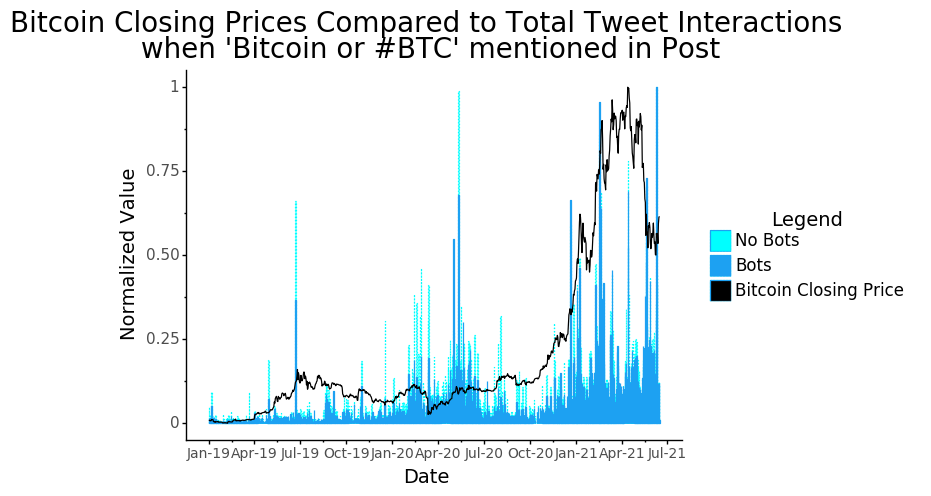

<ggplot: (8784209041735)>

In [97]:
# final daily plot visual used in data story
final_daily = (ggplot(bitcoin,aes(x='Date',group = 1)) # initialize plot
               
      +geom_bar(bitcoin_no_bots, aes(x='Date',y='totalCount_btc_or_bitcoin_norm',fill="'#00FFFF'") # bar excluding bots
                ,color='#00FFFF',linetype='dotted',stat='identity')
               
      +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'#1DA1F2'") # bar including bots
                ,color='#1DA1F2',stat='identity')
               
      +geom_line(aes(y='Close_norm',fill='"black"')
                 ,color='black') # closing prices
      +ggtitle("Bitcoin Closing Prices Compared to Total Tweet Interactions\n when 'Bitcoin or #BTC' mentioned in Post")# title
                   
      +scale_x_date(date_labels = "%b-%y") # change date (x-axis) format
               
      +scale_y_continuous(name='Normalized Value') # relabel y axis
               
      +scale_fill_identity(guide='legend', labels=['No Bots','Bots','Bitcoin Closing Price']
                           ,name='Legend') # legend
                        
      +theme_classic()
               
      +theme(legend_position='right',
             legend_title_align='center',
             legend_title = element_text(size=14),
             legend_text = element_text(size=12),
             axis_title_y = element_text(size=14),
             axis_text_y = element_text(size=11),
             axis_title_x = element_text(size=14),
             axis_text_x = element_text(size=10),
             plot_title = element_text(size=20))
)
final_daily


In [98]:
# saving image
ggsave(plot = final_daily, filename = "final_daily.jpg",width = 15,height = 10,units = "in")

## Hourly Visual included in data story

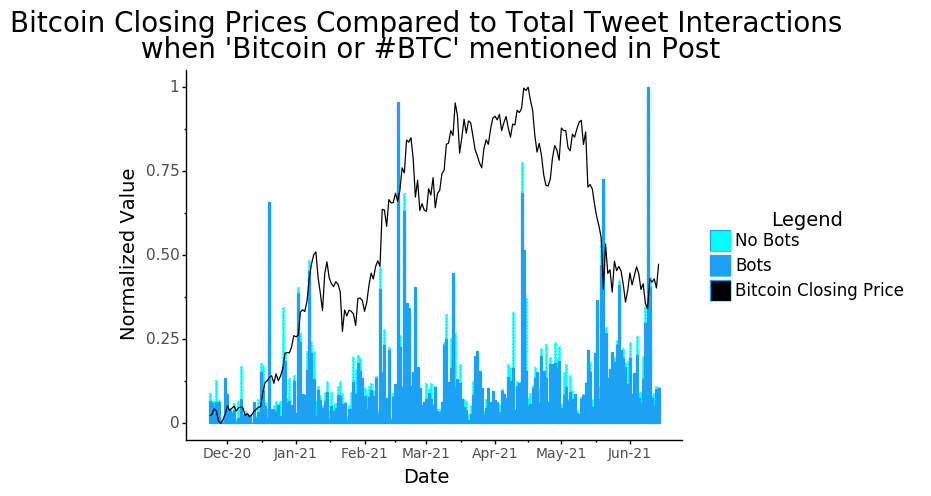

<ggplot: (-9223363252652746443)>

In [99]:
# final hourly plot visual used in data story
# 00FFFF
final_hourly = (ggplot(bitcoin_hourly,aes(x='Date',group = 1)) # initialize plot
 +geom_bar(bitcoin_no_bots_hourly,aes(x='Date',y='totalCount_btc_or_bitcoin_norm',fill="'#00FFFF'") # bar excluding bots
           ,color='#00FFFF', linetype='dotted', stat='identity')
                
 +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'#1DA1F2'") # bar including bots
           ,color='#1DA1F2',stat='identity')
                
 +geom_line(aes(y='Close_norm',fill='"black"') # closing price of bitcoin
            ,color='black')
 +ggtitle("Bitcoin Closing Prices Compared to Total Tweet Interactions\n when 'Bitcoin or #BTC' mentioned in Post") # title
                
 +scale_x_date(date_labels = "%b-%y")# reformat x axis
                
 +scale_y_continuous(name='Normalized Value') # relabel y axis
                
 +scale_fill_identity(guide='legend', labels=['No Bots','Bots','Bitcoin Closing Price'] # change legend
                           ,name='Legend')
                        
 +theme_classic()

 +theme(legend_position='right',
        legend_title_align='center',
        legend_title = element_text(size=14),
        legend_text = element_text(size=12),
        axis_title_y = element_text(size=14),
        axis_text_y = element_text(size=11),
        axis_title_x = element_text(size=14),
        axis_text_x = element_text(size=10),
        plot_title = element_text(size=20))
)
final_hourly

In [100]:
# saving image
ggsave(plot = final_hourly, filename = "final_hourly.jpg",width = 15,height = 10,units = "in")

## Saving elon musk tweets referencing btc/bitcoin

In [101]:
# elon tweets related to bitcoin
elon_bit = elon.loc[(elon['btc_tf']) | (elon['bitcoin_tf'])][['content','Date']].sort_values('Date')

elon_bit.reset_index(drop = True, inplace = True)

elon_bit =elon_bit.set_index('Date')

In [102]:
elon_bit.to_excel("Elon Tweets related to bitcoin.xlsx")

## Sentiment visual included in data story

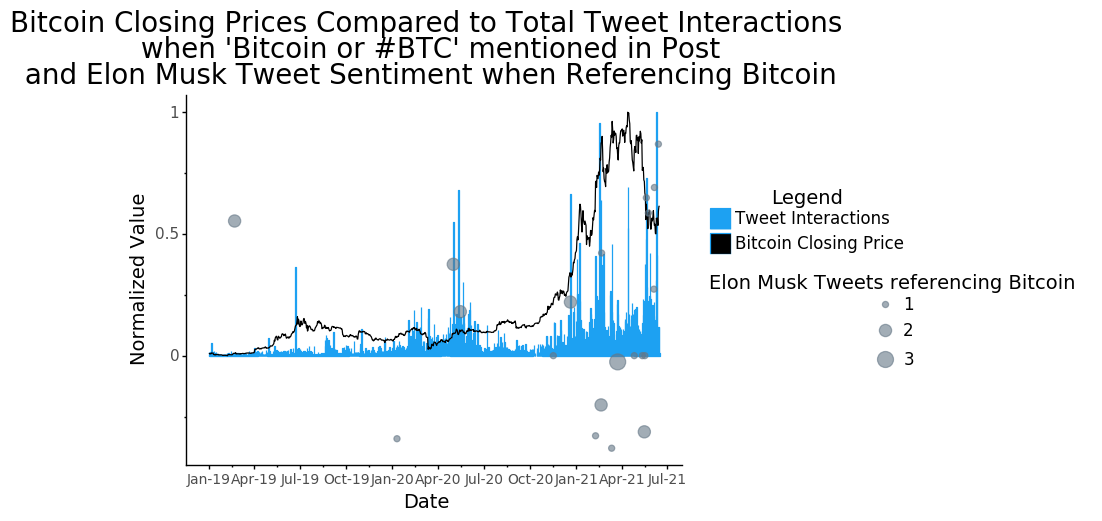

<ggplot: (8784191355368)>

In [103]:
# plot including elon musk tweet sentiment 
final_sentiment = (ggplot(bitcoin_new,aes(x='Date',group = 1))

 +geom_bar(aes(y='totalCount_btc_or_bitcoin_norm',fill="'#1DA1F2'"),color='#1DA1F2',stat='identity')
 +geom_line(aes(y='Close_norm',fill='"black"'),color='black')
 +geom_point(bitcoin_new[bitcoin_new['elon_btc']!=0],aes(y="elon_sentiment_mean",size = 'factor(elon_btc)'),color='#657786',alpha=0.6)
 +ggtitle("Bitcoin Closing Prices Compared to Total Tweet Interactions\n when 'Bitcoin or #BTC' mentioned in Post\n and Elon Musk Tweet Sentiment when Referencing Bitcoin")
 +scale_x_date(date_labels = "%b-%y")
 +scale_y_continuous(name='Normalized Value')
 +scale_fill_identity(guide='legend', labels=['Tweet Interactions','Bitcoin Closing Price'],name='Legend')
 +labs(size = "Elon Musk Tweets referencing Bitcoin")
 +theme_classic()

 +theme(legend_position='right',
        legend_title_align='center',
        legend_title = element_text(size=14),
        legend_text = element_text(size=12),
        axis_title_y = element_text(size=14),
        axis_text_y = element_text(size=11),
        axis_title_x = element_text(size=14),
        axis_text_x = element_text(size=10),
        plot_title = element_text(size=20))
)
final_sentiment

In [104]:
# saving image
ggsave(plot = final_sentiment, filename = "final_sentiment.jpg",width = 15,height = 10,units = "in")

## Section 4: Summary/Key Findings
[Back to Table of Contents](#Table-of-Contents)

These are the visualizations we used in our data story. The first two are identical, except that one uses the daily dataset and the other uses the hourly dataset. In our data story, we highlight the last few months of the daily plot and use a funnel-shaped object to signal that the hourly plot is basically the last few months of the daily plot, zoomed in. The third plot shows how our most influential user, Elon Musk, tweets in relation to bitcoin price, both in terms of volume and sentiment.

# ----------------------------End of Section 4----------------------------

# Section 5: Cross Correlations
[Back to Table of Contents](#Table-of-Contents)

### Overview: 
Cross-correlation is the correlation between two different time-series. You can apply a time lag (offset the time for one series by a specific number of hours, days, etc.) to see if there is a leader/follower effect between the two time-series. Ideally, some of our features will have a stronger correlation with a target variable when we apply a time lag putting the feature before the target variable. This would indicate that bitcoin price, volume, and/or change in price is the result of increased Twitter activity, and not the other way around.

We applied a time lag of 14 days in both directions for the daily dataset and 48 hours in both directions for the hourly dataset to see if correlations between some key features and the target variables, close price and volume, could be significantly improved.

In [105]:
# The following few cells demonstrate that .shift() moves the values forward
# by x days where x is a positive int and back x days if x is a negative int
bitcoin["Date"]

0     2019-01-01
1     2019-01-02
2     2019-01-03
3     2019-01-04
4     2019-01-05
         ...    
888   2021-06-11
889   2021-06-12
890   2021-06-13
891   2021-06-14
892   2021-06-15
Name: Date, Length: 893, dtype: datetime64[ns]

In [106]:
bitcoin["Close"].shift(0)

0       3843.520020
1       3943.409424
2       3836.741211
3       3857.717529
4       3845.194580
           ...     
888    37334.398438
889    35552.515625
890    39097.859375
891    40218.476562
892    40406.269531
Name: Close, Length: 893, dtype: float64

In [107]:
bitcoin["Close"].shift(1)

0               NaN
1       3843.520020
2       3943.409424
3       3836.741211
4       3857.717529
           ...     
888    36702.597656
889    37334.398438
890    35552.515625
891    39097.859375
892    40218.476562
Name: Close, Length: 893, dtype: float64

In [108]:
bitcoin["Close"].shift(-1)

0       3943.409424
1       3836.741211
2       3857.717529
3       3845.194580
4       4076.632568
           ...     
888    35552.515625
889    39097.859375
890    40218.476562
891    40406.269531
892             NaN
Name: Close, Length: 893, dtype: float64

In [109]:
# Create a function which shifts the second variable and computes the new correlation
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [110]:
# columns in bitcoin dataset
pd.options.display.max_seq_items = 102
bitcoin.columns

Index(['Date', 'Close', 'Volume', 'ticker', 'previous_day_close',
       'target_increase', 'replyCount_#AMC', 'replyCount_#BTC',
       'replyCount_#DOGE', 'replyCount_#GME', 'replyCount_#TSLA',
       'replyCount_AMCTheatres', 'replyCount_APompliano',
       'replyCount_BillyM2k', 'replyCount_Bitcoin', 'replyCount_Dogecoin',
       'replyCount_Gamestop', 'replyCount_Mcuban', 'replyCount_SpaceX',
       'replyCount_Tesla', 'replyCount_elonmusk', 'retweetCount_#AMC',
       'retweetCount_#BTC', 'retweetCount_#DOGE', 'retweetCount_#GME',
       'retweetCount_#TSLA', 'retweetCount_AMCTheatres',
       'retweetCount_APompliano', 'retweetCount_BillyM2k',
       'retweetCount_Bitcoin', 'retweetCount_Dogecoin',
       'retweetCount_Gamestop', 'retweetCount_Mcuban', 'retweetCount_SpaceX',
       'retweetCount_Tesla', 'retweetCount_elonmusk', 'likeCount_#AMC',
       'likeCount_#BTC', 'likeCount_#DOGE', 'likeCount_#GME',
       'likeCount_#TSLA', 'likeCount_AMCTheatres', 'likeCount_APompliano'

**totalCount_#BTC vs Close**

In [111]:
# Cross-correlation analysis with a lag range of 14 days in either direction
# Higher correlation on positive lag indicates that the first variable leads
# Higher correlation on negative lag indicates that the second variable leads
corr = 0
max_corr = 0
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_#BTC"], bitcoin["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation, found at lag", j, max_corr)

Cross-Correlation with lag -14 0.6557644349084623
Cross-Correlation with lag -13 0.6567120052000212
Cross-Correlation with lag -12 0.6577095604003922
Cross-Correlation with lag -11 0.6581141787747269
Cross-Correlation with lag -10 0.6571818386390951
Cross-Correlation with lag -9 0.6573430716139107
Cross-Correlation with lag -8 0.6606138053067291
Cross-Correlation with lag -7 0.6603070848180004
Cross-Correlation with lag -6 0.6599637841564954
Cross-Correlation with lag -5 0.6612694863551334
Cross-Correlation with lag -4 0.6590694927161608
Cross-Correlation with lag -3 0.6609650806653432
Cross-Correlation with lag -2 0.6614834885884675
Cross-Correlation with lag -1 0.6664325136342629
Cross-Correlation with lag 0 0.664579396544292
Cross-Correlation with lag 1 0.6686815391182701
Cross-Correlation with lag 2 0.6722000128811897
Cross-Correlation with lag 3 0.67562796045789
Cross-Correlation with lag 4 0.6751354560454208
Cross-Correlation with lag 5 0.6769028964385413
Cross-Correlation with l

In [112]:
# Same as above, but for hourly data
corr = 0
max_corr = 0
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_#BTC"], bitcoin_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation, found at lag", j, max_corr)

Cross-Correlation with lag -48 0.08969698706455222
Cross-Correlation with lag -47 0.07611471640379178
Cross-Correlation with lag -46 0.06923660004039336
Cross-Correlation with lag -45 0.04910437412854151
Cross-Correlation with lag -44 0.03961622316781976
Cross-Correlation with lag -43 0.024828356995998335
Cross-Correlation with lag -42 0.05215187751076453
Cross-Correlation with lag -41 0.05412113830012871
Cross-Correlation with lag -40 0.06672694836706035
Cross-Correlation with lag -39 0.05954527732010328
Cross-Correlation with lag -38 0.08229870701899615
Cross-Correlation with lag -37 0.07837224839581211
Cross-Correlation with lag -36 0.09268677321600961
Cross-Correlation with lag -35 0.0943747998986059
Cross-Correlation with lag -34 0.10731853238152404
Cross-Correlation with lag -33 0.11258630635190645
Cross-Correlation with lag -32 0.12402953548726095
Cross-Correlation with lag -31 0.12372671307246262
Cross-Correlation with lag -30 0.1188944358066297
Cross-Correlation with lag -29 0

In [113]:
# Daily data with no bots
corr = 0
max_corr = 0
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_#BTC"], bitcoin_no_bots["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation, found at lag", j, max_corr)

Cross-Correlation with lag -14 0.5488557852094698
Cross-Correlation with lag -13 0.5502662369703496
Cross-Correlation with lag -12 0.5513398188473525
Cross-Correlation with lag -11 0.5523541056181915
Cross-Correlation with lag -10 0.5490732103061666
Cross-Correlation with lag -9 0.5506587134879198
Cross-Correlation with lag -8 0.5549122360209348
Cross-Correlation with lag -7 0.5573295527441252
Cross-Correlation with lag -6 0.5579195814429738
Cross-Correlation with lag -5 0.5601437344282527
Cross-Correlation with lag -4 0.557119644159183
Cross-Correlation with lag -3 0.5584870056642554
Cross-Correlation with lag -2 0.5601279764709796
Cross-Correlation with lag -1 0.5631267188404051
Cross-Correlation with lag 0 0.5605838051459335
Cross-Correlation with lag 1 0.5637869449054811
Cross-Correlation with lag 2 0.5645306921632838
Cross-Correlation with lag 3 0.5665761550918311
Cross-Correlation with lag 4 0.5660483783315563
Cross-Correlation with lag 5 0.5672671869914812
Cross-Correlation with

In [114]:
# Hourly data with no bots
corr = 0
max_corr = 0
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_#BTC"], bitcoin_no_bots_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation, found at lag", j, max_corr)

Cross-Correlation with lag -48 0.029823481655712945
Cross-Correlation with lag -47 0.009921985311870385
Cross-Correlation with lag -46 0.014209249868813764
Cross-Correlation with lag -45 -0.0038109692540133034
Cross-Correlation with lag -44 -0.018552203408915002
Cross-Correlation with lag -43 -0.03207044989175922
Cross-Correlation with lag -42 -0.01579950432154714
Cross-Correlation with lag -41 -0.030841495279740665
Cross-Correlation with lag -40 -0.006712158085789786
Cross-Correlation with lag -39 -0.029514808404938985
Cross-Correlation with lag -38 -0.00779988734678586
Cross-Correlation with lag -37 -0.012756492756505068
Cross-Correlation with lag -36 0.028891397360143952
Cross-Correlation with lag -35 0.03378499919476501
Cross-Correlation with lag -34 0.06258336974120762
Cross-Correlation with lag -33 0.08755286098855121
Cross-Correlation with lag -32 0.10419235648480672
Cross-Correlation with lag -31 0.11507148317588316
Cross-Correlation with lag -30 0.10116796707076355
Cross-Corre

In the daily dataset, a lag of 13 days improved the correlation from 0.666 to 0.689, an insignificant change.
In the hourly dataset, a lag of 48 hours improved the correlation from 0.272 to 0.385, a decent change.
The datasets without bots experienced smaller changes in correlation than the ones with bots.

Possible totalCount_#BTC possibly leads Close by 48 hours

**totalCount_#BTC vs Volume**

In [115]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_#BTC"], bitcoin["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_#BTC"], bitcoin_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_#BTC"], bitcoin_no_bots["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_#BTC"], bitcoin_no_bots_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.48571819331554617
Cross-Correlation with lag -13 0.46145519721505407
Cross-Correlation with lag -12 0.45064052471350746
Cross-Correlation with lag -11 0.45770382028939055
Cross-Correlation with lag -10 0.4682717904433226
Cross-Correlation with lag -9 0.49985596512814956
Cross-Correlation with lag -8 0.4936798615999412
Cross-Correlation with lag -7 0.5471665446247314
Cross-Correlation with lag -6 0.5017448236002885
Cross-Correlation with lag -5 0.5084993882007448
Cross-Correlation with lag -4 0.5267122471764982
Cross-Correlation with lag -3 0.5479567247628857
Cross-Correlation with lag -2 0.5774311817889959
Cross-Correlation with lag -1 0.5598607308697645
Cross-Correlation with lag 0 0.6023671560878952
Cross-Correlation with lag 1 0.5513404003602623
Cross-Correlation with lag 2 0.5358952676709736
Cross-Correlation with lag 3 0.533596541958355
Cross-Correlation with lag 4 0.5302909039446553
Cross-Correlation with lag 5 0.5121316953497056
Cross

Cross-Correlation with lag -38 -0.07265996251610879
Cross-Correlation with lag -37 -0.06920460945085097
Cross-Correlation with lag -36 -0.0014832980669194896
Cross-Correlation with lag -35 -0.09399531761301765
Cross-Correlation with lag -34 0.26510300382498164
Cross-Correlation with lag -33 0.13261986407076104
Cross-Correlation with lag -32 -0.0161684721689415
Cross-Correlation with lag -31 0.038907201076472823
Cross-Correlation with lag -30 0.015717058878968737
Cross-Correlation with lag -29 -0.035211820499204564
Cross-Correlation with lag -28 0.137604782729612
Cross-Correlation with lag -27 0.05411222609114197
Cross-Correlation with lag -26 -0.06519315673051725
Cross-Correlation with lag -25 -0.04326797971376996
Cross-Correlation with lag -24 -0.07613870521786875
Cross-Correlation with lag -23 -0.08108260536890405
Cross-Correlation with lag -22 -0.025285207030476514
Cross-Correlation with lag -21 -0.04005355403992141
Cross-Correlation with lag -20 0.039916843539604535
Cross-Correlati

In the daily dataset, lag 0 contained the best correlation
In the hourly dataset, a lag of 33 hours improved the correlation from -0.012 to 0.563, a HUGE change.
The datasets without bots experienced smaller changes in correlation than the ones with bots.

This is an odd result because 33 hours results in pretty good correlation, but no other shift is anywhere near it, which means it's either the perfect amount to shift by or a coincidence.

**totalCount_#BTC vs target_increase**

In [116]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_#BTC"], bitcoin["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_#BTC"], bitcoin_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_#BTC"], bitcoin_no_bots["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_#BTC"], bitcoin_no_bots_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.007907125423728595
Cross-Correlation with lag -13 -0.01909079717669426
Cross-Correlation with lag -12 -0.0018108725408205691
Cross-Correlation with lag -11 0.006380104749544341
Cross-Correlation with lag -10 -0.010791761341942388
Cross-Correlation with lag -9 -0.02682184642858807
Cross-Correlation with lag -8 -0.02621737678313097
Cross-Correlation with lag -7 -0.012939856821375129
Cross-Correlation with lag -6 -0.009768586433426135
Cross-Correlation with lag -5 0.018991766959642956
Cross-Correlation with lag -4 -0.04195531359870823
Cross-Correlation with lag -3 -0.023286426079719785
Cross-Correlation with lag -2 -0.0128428327758606
Cross-Correlation with lag -1 -0.015393503712493187
Cross-Correlation with lag 0 -0.04949826922116388
Cross-Correlation with lag 1 -0.039771764943515794
Cross-Correlation with lag 2 0.009427512719228228
Cross-Correlation with lag 3 -0.003718739259322001
Cross-Correlation with lag 4 0.01333923608232347
Cross-Correl

Cross-Correlation with lag -32 -0.04673046230715957
Cross-Correlation with lag -31 0.12982799732192019
Cross-Correlation with lag -30 -0.07512939606562566
Cross-Correlation with lag -29 0.012203910288116331
Cross-Correlation with lag -28 0.10520944028760605
Cross-Correlation with lag -27 0.019620349967845188
Cross-Correlation with lag -26 0.005983271272318489
Cross-Correlation with lag -25 0.11010532456860281
Cross-Correlation with lag -24 -0.10771210255538692
Cross-Correlation with lag -23 -0.09770423228254141
Cross-Correlation with lag -22 -0.004896127323244322
Cross-Correlation with lag -21 -0.03143694461349056
Cross-Correlation with lag -20 0.019667928449076
Cross-Correlation with lag -19 0.03769389952707325
Cross-Correlation with lag -18 0.09182862182785065
Cross-Correlation with lag -17 0.034362328915238306
Cross-Correlation with lag -16 -0.00727151666406646
Cross-Correlation with lag -15 -0.04629356700001257
Cross-Correlation with lag -14 -0.08978915451509048
Cross-Correlation w

No significant correlations

**previous_day_close vs Close (This should have perfect correlation with 1 day lag)**

In [117]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["previous_day_close"], bitcoin["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["previous_day_close"], bitcoin_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["previous_day_close"], bitcoin_no_bots["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["previous_day_close"], bitcoin_no_bots_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.9660353469742313
Cross-Correlation with lag -13 0.9680098766097257
Cross-Correlation with lag -12 0.970577954193635
Cross-Correlation with lag -11 0.9729602921157839
Cross-Correlation with lag -10 0.9758336446282989
Cross-Correlation with lag -9 0.9784307230360627
Cross-Correlation with lag -8 0.9807131873157267
Cross-Correlation with lag -7 0.982829766935231
Cross-Correlation with lag -6 0.9852212601479019
Cross-Correlation with lag -5 0.9876971005299837
Cross-Correlation with lag -4 0.989911828761871
Cross-Correlation with lag -3 0.9922321091188484
Cross-Correlation with lag -2 0.9943683571897736
Cross-Correlation with lag -1 0.9963871897159399
Cross-Correlation with lag 0 0.9980288380932362
Cross-Correlation with lag 1 0.9999999999999999
Cross-Correlation with lag 2 0.9980222588593601
Cross-Correlation with lag 3 0.9963787341620395
Cross-Correlation with lag 4 0.9944022163179141
Cross-Correlation with lag 5 0.9922268088713383
Cross-Correl

Cross-Correlation with lag -17 0.7836552672285179
Cross-Correlation with lag -16 0.7948006472358099
Cross-Correlation with lag -15 0.8071329418684297
Cross-Correlation with lag -14 0.818660645721213
Cross-Correlation with lag -13 0.8334603797850675
Cross-Correlation with lag -12 0.8476434911501052
Cross-Correlation with lag -11 0.8654403926652571
Cross-Correlation with lag -10 0.8809376450154698
Cross-Correlation with lag -9 0.8941894085771696
Cross-Correlation with lag -8 0.9064730586438366
Cross-Correlation with lag -7 0.9199631118746563
Cross-Correlation with lag -6 0.9338716636691851
Cross-Correlation with lag -5 0.9447617103841408
Cross-Correlation with lag -4 0.9579405988501865
Cross-Correlation with lag -3 0.9685772075582281
Cross-Correlation with lag -2 0.9795959250919419
Cross-Correlation with lag -1 0.9881494786623702
Cross-Correlation with lag 0 0.9992785933078169
Cross-Correlation with lag 1 0.9894547723909781
Cross-Correlation with lag 2 0.9809310634484778
Cross-Correlatio

This was a test and is irrelevant to the question we are trying to answer

**totalCount_bitcoin vs Close**

In [118]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_Bitcoin"], bitcoin["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_Bitcoin"], bitcoin_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_Bitcoin"], bitcoin_no_bots["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_Bitcoin"], bitcoin_no_bots_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.21852066964427447
Cross-Correlation with lag -13 0.22118318977872442
Cross-Correlation with lag -12 0.2132638032238261
Cross-Correlation with lag -11 0.2153857055253748
Cross-Correlation with lag -10 0.2133100006649321
Cross-Correlation with lag -9 0.21094629827659087
Cross-Correlation with lag -8 0.21728605993542682
Cross-Correlation with lag -7 0.2241472907192725
Cross-Correlation with lag -6 0.23156719855880095
Cross-Correlation with lag -5 0.23726892641794084
Cross-Correlation with lag -4 0.23713900975394214
Cross-Correlation with lag -3 0.23447020241067096
Cross-Correlation with lag -2 0.23439852222483157
Cross-Correlation with lag -1 0.23599582130839156
Cross-Correlation with lag 0 0.23587891483519433
Cross-Correlation with lag 1 0.21894700735448078
Cross-Correlation with lag 2 0.2178359633450806
Cross-Correlation with lag 3 0.2145998720807676
Cross-Correlation with lag 4 0.21174226027049226
Cross-Correlation with lag 5 0.2099761688704

Cross-Correlation with lag -16 0.05975394732727494
Cross-Correlation with lag -15 0.06255432386037317
Cross-Correlation with lag -14 0.07171239226014775
Cross-Correlation with lag -13 0.05575443556863217
Cross-Correlation with lag -12 0.05860667295828709
Cross-Correlation with lag -11 0.05274806031058262
Cross-Correlation with lag -10 0.04268026764831331
Cross-Correlation with lag -9 0.07049353936791895
Cross-Correlation with lag -8 0.08694669630525592
Cross-Correlation with lag -7 0.09397769071875554
Cross-Correlation with lag -6 0.10021901247608331
Cross-Correlation with lag -5 0.09414234605923784
Cross-Correlation with lag -4 0.08726436648953342
Cross-Correlation with lag -3 0.08822435982028115
Cross-Correlation with lag -2 0.09923605574760912
Cross-Correlation with lag -1 0.10320414752062866
Cross-Correlation with lag 0 0.04992864584311807
Cross-Correlation with lag 1 0.048680619929285615
Cross-Correlation with lag 2 0.04432956326289425
Cross-Correlation with lag 3 0.03433279836486

Small increase in correlations with negative time-shift, indicating total tweet interactions involving the term "bitcoin" follow close price. The correlations are small, all around 0.2

**totalCount_Bitcoin vs Volume**

In [119]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_Bitcoin"], bitcoin["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_Bitcoin"], bitcoin_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_Bitcoin"], bitcoin_no_bots["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_Bitcoin"], bitcoin_no_bots_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.20713969656676823
Cross-Correlation with lag -13 0.1805728267414267
Cross-Correlation with lag -12 0.1889852406598709
Cross-Correlation with lag -11 0.18446016081512712
Cross-Correlation with lag -10 0.39903702655025663
Cross-Correlation with lag -9 0.2531305645940409
Cross-Correlation with lag -8 0.2396759339209595
Cross-Correlation with lag -7 0.35837362219680646
Cross-Correlation with lag -6 0.3070886687459805
Cross-Correlation with lag -5 0.2812880364706282
Cross-Correlation with lag -4 0.2652318150809488
Cross-Correlation with lag -3 0.2620519506419037
Cross-Correlation with lag -2 0.27071389971045895
Cross-Correlation with lag -1 0.2769235000081363
Cross-Correlation with lag 0 0.2951572856599792
Cross-Correlation with lag 1 0.29059157893302
Cross-Correlation with lag 2 0.22854990194185323
Cross-Correlation with lag 3 0.22788760653793008
Cross-Correlation with lag 4 0.2590826319464412
Cross-Correlation with lag 5 0.2355829538550989
Cros

Cross-Correlation with lag -17 -0.02004776734285324
Cross-Correlation with lag -16 -0.02150950989885777
Cross-Correlation with lag -15 0.0037938169637761186
Cross-Correlation with lag -14 -0.0007036668592478079
Cross-Correlation with lag -13 0.12341320655968499
Cross-Correlation with lag -12 0.02717266366514307
Cross-Correlation with lag -11 -0.07400129748663727
Cross-Correlation with lag -10 -0.00678306859205539
Cross-Correlation with lag -9 -0.024405934879427656
Cross-Correlation with lag -8 -0.01655330966920824
Cross-Correlation with lag -7 -0.08233006738243283
Cross-Correlation with lag -6 -0.06707206906838785
Cross-Correlation with lag -5 -0.047557462525886676
Cross-Correlation with lag -4 -0.02918405628703359
Cross-Correlation with lag -3 -0.10541068060911976
Cross-Correlation with lag -2 -0.0795394985822472
Cross-Correlation with lag -1 -0.0022295834590096947
Cross-Correlation with lag 0 0.0024458959131604097
Cross-Correlation with lag 1 -0.062344334600026564
Cross-Correlation w

In the daily dataset, a lag of -10 days improved the correlation from 0.295 to 0.400 a decent change to a moderate correlation.
In the hourly dataset, a lag of -30 hours improved the correlation from 0.005 to 0.24, a decent change to a low correlation.
The datasets without bots experienced smaller changes in correlation than the ones with bots.

**totalCount_Bitcoin vs target_increase**

In [120]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_Bitcoin"], bitcoin["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_Bitcoin"], bitcoin_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_Bitcoin"], bitcoin_no_bots["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_Bitcoin"], bitcoin_no_bots_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 -0.03878211096633213
Cross-Correlation with lag -13 0.00040024331969209305
Cross-Correlation with lag -12 -0.032392407487587926
Cross-Correlation with lag -11 -0.028094822895495964
Cross-Correlation with lag -10 -0.03912363463369583
Cross-Correlation with lag -9 -0.11202515769460213
Cross-Correlation with lag -8 -0.06060873582254753
Cross-Correlation with lag -7 -0.03258895479108839
Cross-Correlation with lag -6 0.015084038672605543
Cross-Correlation with lag -5 0.009423201770341911
Cross-Correlation with lag -4 0.014081838683169224
Cross-Correlation with lag -3 0.005445848013541297
Cross-Correlation with lag -2 -0.00605281208030974
Cross-Correlation with lag -1 0.004012256753750968
Cross-Correlation with lag 0 0.06288974708990207
Cross-Correlation with lag 1 -0.03547922808286614
Cross-Correlation with lag 2 0.015222374750883791
Cross-Correlation with lag 3 0.0261156938161883
Cross-Correlation with lag 4 -0.00494104725745473
Cross-Correlation 

Cross-Correlation with lag -20 -0.06931144053464117
Cross-Correlation with lag -19 0.10483761108305885
Cross-Correlation with lag -18 0.04044658821022201
Cross-Correlation with lag -17 -0.08005218094073258
Cross-Correlation with lag -16 -0.012572869447974137
Cross-Correlation with lag -15 0.00207364008927432
Cross-Correlation with lag -14 -0.134256206709674
Cross-Correlation with lag -13 0.0398167427460038
Cross-Correlation with lag -12 0.11328753181821874
Cross-Correlation with lag -11 0.01957927048466081
Cross-Correlation with lag -10 -0.04465471195549233
Cross-Correlation with lag -9 0.10554649545676294
Cross-Correlation with lag -8 -0.003050171669151336
Cross-Correlation with lag -7 -0.08502572699178218
Cross-Correlation with lag -6 -0.11591569278887262
Cross-Correlation with lag -5 -0.009930734784330375
Cross-Correlation with lag -4 0.07031352448052042
Cross-Correlation with lag -3 -0.08420492505193282
Cross-Correlation with lag -2 -0.06659991038854643
Cross-Correlation with lag -

No significant correlations

**totalCount_btc_or_bitcoin vs Close**

In [121]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_btc_or_bitcoin"], bitcoin["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_btc_or_bitcoin"], bitcoin_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_btc_or_bitcoin"], bitcoin_no_bots["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_btc_or_bitcoin"], bitcoin_no_bots_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.5177544419786213
Cross-Correlation with lag -13 0.520503077312738
Cross-Correlation with lag -12 0.5154625096268931
Cross-Correlation with lag -11 0.5172089685130776
Cross-Correlation with lag -10 0.5154493152695417
Cross-Correlation with lag -9 0.513986605407091
Cross-Correlation with lag -8 0.5210534476738009
Cross-Correlation with lag -7 0.5274958986756167
Cross-Correlation with lag -6 0.5171665996733493
Cross-Correlation with lag -5 0.520317768934023
Cross-Correlation with lag -4 0.5192680263207328
Cross-Correlation with lag -3 0.5184428969534856
Cross-Correlation with lag -2 0.5190708710642499
Cross-Correlation with lag -1 0.5232627985894663
Cross-Correlation with lag 0 0.5221794305375209
Cross-Correlation with lag 1 0.5122480244284153
Cross-Correlation with lag 2 0.5133292027228405
Cross-Correlation with lag 3 0.5128361466512963
Cross-Correlation with lag 4 0.510532509317879
Cross-Correlation with lag 5 0.5102164434469131
Cross-Correla

Cross-Correlation with lag -25 0.142042693331223
Cross-Correlation with lag -24 0.15169568789461596
Cross-Correlation with lag -23 0.1630856060274891
Cross-Correlation with lag -22 0.1628717857663286
Cross-Correlation with lag -21 0.14455477760375016
Cross-Correlation with lag -20 0.13175403637811642
Cross-Correlation with lag -19 0.1357002774211045
Cross-Correlation with lag -18 0.12925897779594103
Cross-Correlation with lag -17 0.09828644597449178
Cross-Correlation with lag -16 0.10215708745335571
Cross-Correlation with lag -15 0.1099874862438303
Cross-Correlation with lag -14 0.117566492885793
Cross-Correlation with lag -13 0.1072829998788759
Cross-Correlation with lag -12 0.11037292144633651
Cross-Correlation with lag -11 0.09952851746299433
Cross-Correlation with lag -10 0.09434785584773998
Cross-Correlation with lag -9 0.12076036765971936
Cross-Correlation with lag -8 0.1407380743795708
Cross-Correlation with lag -7 0.14554029466275945
Cross-Correlation with lag -6 0.153066276671

Slight increases with -7 day lag, probably insignificant

**totalCount_btc_or_bitcoin vs Volume**

In [122]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_btc_or_bitcoin"], bitcoin["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_btc_or_bitcoin"], bitcoin_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_btc_or_bitcoin"], bitcoin_no_bots["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_btc_or_bitcoin"], bitcoin_no_bots_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.41585797338218616
Cross-Correlation with lag -13 0.38371899700148293
Cross-Correlation with lag -12 0.3837892325199219
Cross-Correlation with lag -11 0.3844303573782635
Cross-Correlation with lag -10 0.5434744600473314
Cross-Correlation with lag -9 0.4569789771019814
Cross-Correlation with lag -8 0.44449195927765084
Cross-Correlation with lag -7 0.5596637428557941
Cross-Correlation with lag -6 0.48726546793533554
Cross-Correlation with lag -5 0.47093451641418316
Cross-Correlation with lag -4 0.4692439227529294
Cross-Correlation with lag -3 0.4782972734855178
Cross-Correlation with lag -2 0.5004774923246962
Cross-Correlation with lag -1 0.4959455833067012
Cross-Correlation with lag 0 0.5315811482786107
Cross-Correlation with lag 1 0.5012103219146251
Cross-Correlation with lag 2 0.44856471421975785
Cross-Correlation with lag 3 0.4468752211444577
Cross-Correlation with lag 4 0.46748107786487236
Cross-Correlation with lag 5 0.44100386306794426
C

Cross-Correlation with lag -29 0.08452499426059343
Cross-Correlation with lag -28 0.032944630932244784
Cross-Correlation with lag -27 0.05416857869845721
Cross-Correlation with lag -26 -0.03892372119757483
Cross-Correlation with lag -25 -0.08146222549349084
Cross-Correlation with lag -24 -0.05816639255213058
Cross-Correlation with lag -23 -0.11851684175241183
Cross-Correlation with lag -22 0.017028599270613565
Cross-Correlation with lag -21 -0.017655048712817464
Cross-Correlation with lag -20 0.0597942745808479
Cross-Correlation with lag -19 0.05058786388392875
Cross-Correlation with lag -18 -0.009929711586547242
Cross-Correlation with lag -17 -0.029020084659946384
Cross-Correlation with lag -16 -0.06529049390762229
Cross-Correlation with lag -15 0.007016628076381146
Cross-Correlation with lag -14 -0.0409545215644017
Cross-Correlation with lag -13 0.11982606689879172
Cross-Correlation with lag -12 -0.01572031379282845
Cross-Correlation with lag -11 -0.03452981117414925
Cross-Correlatio

Increases in correlation are insignificant

**totalCount_btc_or_bitcoin vs target_increase**

In [123]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_btc_or_bitcoin"], bitcoin["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_btc_or_bitcoin"], bitcoin_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_btc_or_bitcoin"], bitcoin_no_bots["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_btc_or_bitcoin"], bitcoin_no_bots_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 -0.02335608099627331
Cross-Correlation with lag -13 -0.010250332906776575
Cross-Correlation with lag -12 -0.024133121633936144
Cross-Correlation with lag -11 -0.016512769196800618
Cross-Correlation with lag -10 -0.03386934550074999
Cross-Correlation with lag -9 -0.09473431995116048
Cross-Correlation with lag -8 -0.057739938570287204
Cross-Correlation with lag -7 -0.03035376805725528
Cross-Correlation with lag -6 0.005636281493664932
Cross-Correlation with lag -5 0.016813044032258938
Cross-Correlation with lag -4 -0.012147232891727455
Cross-Correlation with lag -3 -0.008442673803750538
Cross-Correlation with lag -2 -0.011154050612302036
Cross-Correlation with lag -1 -0.005306601098824163
Cross-Correlation with lag 0 0.018745868118585696
Cross-Correlation with lag 1 -0.04655567376165779
Cross-Correlation with lag 2 0.01591720192942629
Cross-Correlation with lag 3 0.01673723546713
Cross-Correlation with lag 4 0.003548180120024609
Cross-Correlatio

Cross-Correlation with lag -29 0.06715945820168075
Cross-Correlation with lag -28 -0.03248587604899044
Cross-Correlation with lag -27 0.1139912168312818
Cross-Correlation with lag -26 0.02501858098312824
Cross-Correlation with lag -25 -0.01960611770474006
Cross-Correlation with lag -24 -0.0005433800130700357
Cross-Correlation with lag -23 -0.09673086205031449
Cross-Correlation with lag -22 0.0005872711477890482
Cross-Correlation with lag -21 -0.08618830520962398
Cross-Correlation with lag -20 -0.04662611721057698
Cross-Correlation with lag -19 0.1072740387500656
Cross-Correlation with lag -18 0.08307833628796188
Cross-Correlation with lag -17 -0.04782803251997882
Cross-Correlation with lag -16 -0.014344810965850385
Cross-Correlation with lag -15 -0.02322624027210517
Cross-Correlation with lag -14 -0.15996752125129193
Cross-Correlation with lag -13 -0.018035804430339943
Cross-Correlation with lag -12 0.06354199062561337
Cross-Correlation with lag -11 0.026983012792885844
Cross-Correlati

No significant correlations

**totalCount_elonmusk vs Close**

In [124]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_elonmusk"], bitcoin["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_elonmusk"], bitcoin_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_elonmusk"], bitcoin_no_bots["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_elonmusk"], bitcoin_no_bots_hourly["Close"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.323134088498346
Cross-Correlation with lag -13 0.3252202862077169
Cross-Correlation with lag -12 0.3210114681607645
Cross-Correlation with lag -11 0.3251205544595609
Cross-Correlation with lag -10 0.32023899025187713
Cross-Correlation with lag -9 0.3210545645833001
Cross-Correlation with lag -8 0.32009073461979737
Cross-Correlation with lag -7 0.32095116318828026
Cross-Correlation with lag -6 0.31765124415964235
Cross-Correlation with lag -5 0.3187706253580663
Cross-Correlation with lag -4 0.3163299027901229
Cross-Correlation with lag -3 0.30557951583315324
Cross-Correlation with lag -2 0.30985277746444106
Cross-Correlation with lag -1 0.310425169459894
Cross-Correlation with lag 0 0.3060164977816099
Cross-Correlation with lag 1 0.30451158192874006
Cross-Correlation with lag 2 0.3063211794263654
Cross-Correlation with lag 3 0.3037928240639262
Cross-Correlation with lag 4 0.30753598503592866
Cross-Correlation with lag 5 0.3041353134793314
Cro

At -42 hour lag, the correlations for the hourly datasets increase from around 0.20 to 0.25, a small improvement.

**totalCount_elonmusk vs Volume**

In [125]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_elonmusk"], bitcoin["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_elonmusk"], bitcoin_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_elonmusk"], bitcoin_no_bots["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_elonmusk"], bitcoin_no_bots_hourly["Volume"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.22127168432076552
Cross-Correlation with lag -13 0.29241131789469854
Cross-Correlation with lag -12 0.25162763479393396
Cross-Correlation with lag -11 0.26956796117443566
Cross-Correlation with lag -10 0.23500471122315197
Cross-Correlation with lag -9 0.24073076017577646
Cross-Correlation with lag -8 0.23706242388490326
Cross-Correlation with lag -7 0.2880642274630173
Cross-Correlation with lag -6 0.2853519254120654
Cross-Correlation with lag -5 0.25622178682691543
Cross-Correlation with lag -4 0.2644083245902809
Cross-Correlation with lag -3 0.2643371772423831
Cross-Correlation with lag -2 0.2824306786551437
Cross-Correlation with lag -1 0.3299136984812519
Cross-Correlation with lag 0 0.28381363775705454
Cross-Correlation with lag 1 0.25966417637548395
Cross-Correlation with lag 2 0.2591645743213807
Cross-Correlation with lag 3 0.2883274276226796
Cross-Correlation with lag 4 0.2400996067707001
Cross-Correlation with lag 5 0.2326749199690435

For the daily datasets, lag of -1 increases correlation from around 0.28 to around 0.32

**totalCount_elonmusk vs target_increase**

In [126]:
# Daily data with bots
corr = 0
max_corr = 0
print("Daily/bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin["totalCount_elonmusk"], bitcoin["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/bots, found at lag", j, max_corr)

# Hourly data with bots
corr = 0
max_corr = 0
print("Hourly/bots:")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_hourly["totalCount_elonmusk"], bitcoin_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/bots, found at lag", j, max_corr)

# Daily data with no bots
corr = 0
max_corr = 0
print("Daily/no bots:")
for i in range(-14, 15):
    corr = crosscorr(bitcoin_no_bots["totalCount_elonmusk"], bitcoin_no_bots["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for daily/no bots, found at lag", j, max_corr)

# Hourly data with no bots
corr = 0
max_corr = 0
print("Hourly/no bots")
for i in range(-48, 49):
    corr = crosscorr(bitcoin_no_bots_hourly["totalCount_elonmusk"], bitcoin_no_bots_hourly["target_increase"], i)
    if abs(corr) > abs(max_corr):
        max_corr = corr
        j = i
    print("Cross-Correlation with lag", i, corr)
print("Maximum correlation for hourly/no bots, found at lag", j, max_corr)

Daily/bots:
Cross-Correlation with lag -14 0.020355281403068578
Cross-Correlation with lag -13 0.025425626706040014
Cross-Correlation with lag -12 0.021073226341319726
Cross-Correlation with lag -11 0.008446916567378658
Cross-Correlation with lag -10 -0.012742087049223534
Cross-Correlation with lag -9 -0.03849935622154092
Cross-Correlation with lag -8 0.008219081748253435
Cross-Correlation with lag -7 -0.03946984376743233
Cross-Correlation with lag -6 -0.018116588253401848
Cross-Correlation with lag -5 0.02796056987907294
Cross-Correlation with lag -4 0.012786381495112601
Cross-Correlation with lag -3 -0.015499700489822745
Cross-Correlation with lag -2 -0.04186987256547794
Cross-Correlation with lag -1 0.0381576847029943
Cross-Correlation with lag 0 0.014244611592378257
Cross-Correlation with lag 1 0.021596022730741
Cross-Correlation with lag 2 -0.01612990352767766
Cross-Correlation with lag 3 -0.0549873264433883
Cross-Correlation with lag 4 0.04836652780646623
Cross-Correlation with l

No significant correlations

## Section 5: Summary/Key Findings
[Back to Table of Contents](#Table-of-Contents)

Pairs that experienced not insignificant improvements in correlation to a correlation with an absolute value of 0.3 or higher:

totalCount_#BTC vs Close: <br/>
	48 hours, start: 0.272, end: 0.385, change in abs. value: 0.113 <br/>
totalCount_#BTC vs Volume: <br/>
	33 hours, start: -0.012, end: 0.563, change in abs. value: 0.551 <br/>
totalCount_Bitcoin vs Volume: <br/>
	-10 days, start: 0.295, end: 0.400, change in abs. value: 0.105 <br/>
totalCount_elonmusk vs Volume: <br/>
	-1 day, start: 0.285, end: 0.329, change in abs. value: 0.044 <br/>
    
The top two pairs listed have improved correlations with a positive lag, indicating that price and volume followed totalCount_#BTC. The other two pairs have improved correlations with negative lag, indicating that totalCount_Bitcoin and totalCount_elonmusk followed Volume. Of the three target variables, Volume appears to be the most correlated with the features. totalCount_#BTC was the only feature tested whose correlation with price improved when price was shifted forward in time. totalCount#BTC's correlation with volume drastically improved with a time-shift of 33 hours. Other nearby hours had far worse results, so it could just be a coincidence.

# ----------------------------End of Section 5----------------------------

# Section 6: Linear Regression
[Back to Table of Contents](#Table-of-Contents)

### Overview: 
The previous section helped to hone in on individual features to try a linear regression on and by what amount of time to shift the variables by in order to get the best results. This section includes linear regression plots involving close price, volume, and the variables that correlated the most with price and volume.

In [127]:
# The following few cells contain the linear regression work for the pair of variables totalCount_#BTC and Close
# This process will be copied for each of the four pairs above

# Split the data into a train/test set
X1 = bitcoin_hourly["totalCount_#BTC"].values[:,np.newaxis]
y1 = bitcoin_hourly["Close"].values

#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1)

# verify split shapes and contents
#print("X_train.shape: ", X1_train.shape)
#print("y_train.shape: ", y1_train.shape)
#print("X_test.shape: ", X1_test.shape)
#print("y_test.shape: ", y1_test.shape)

In [128]:
lm = LinearRegression()
lm.fit(X1, y1)
lm.score(X1, y1)

0.031559826043131456

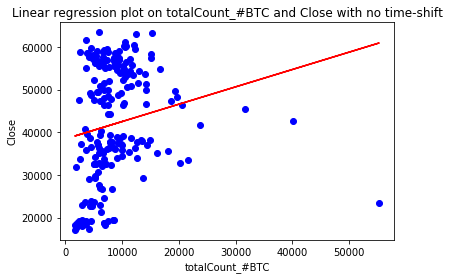

In [129]:
plt.title('Linear regression plot on totalCount_#BTC and Close with no time-shift')
plt.scatter(X1, y1, color='blue')
plt.plot(X1, lm.predict(X1), color='red')
plt.xlabel('totalCount_#BTC')
plt.ylabel('Close')
plt.show()

In [130]:
y1_shifted = bitcoin_hourly['Close'].shift(48)
y1_shifted = y1_shifted[48:]
X1_shifted = X1[48:]

In [131]:
lm.fit(X1_shifted, y1_shifted)
lm.score(X1_shifted, y1_shifted)

0.131616932223664

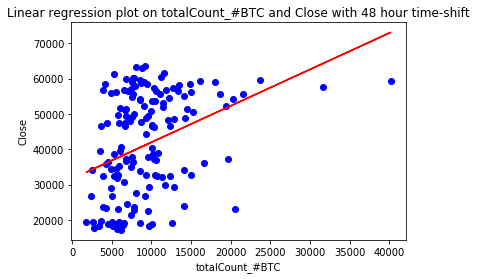

In [132]:
plt.title('Linear regression plot on totalCount_#BTC and Close with 48 hour time-shift')
plt.scatter(X1_shifted, y1_shifted, color='blue')
plt.plot(X1_shifted, lm.predict(X1_shifted), color='red')
plt.xlabel('totalCount_#BTC')
plt.ylabel('Close')
plt.show()

The R^2 increased by a lot by applying the time-shift, but it is still quite low.

In [133]:
#totalCount_#BTC vs Volume

# Split the data into a train/test set
X2 = bitcoin_hourly["totalCount_#BTC"].values[:,np.newaxis]
y2 = bitcoin_hourly["Volume"].values

In [134]:
lm.fit(X2, y2)
lm.score(X2, y2)

0.007676785210648851

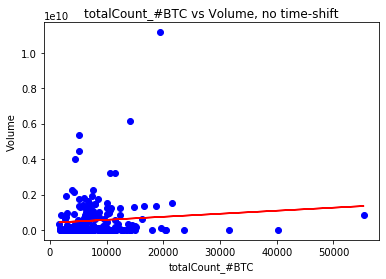

In [135]:
plt.title('totalCount_#BTC vs Volume, no time-shift')
plt.scatter(X2, y2, color='blue')
plt.plot(X2, lm.predict(X2), color='red')
plt.xlabel('totalCount_#BTC')
plt.ylabel('Volume')
plt.show()

In [136]:
y2_shifted = bitcoin_hourly['Volume'].shift(33)
y2_shifted = y2_shifted[33:]
X2_shifted = X2[33:]

In [137]:
lm.fit(X2_shifted, y2_shifted)
lm.score(X2_shifted, y2_shifted)

0.00018482758862059523

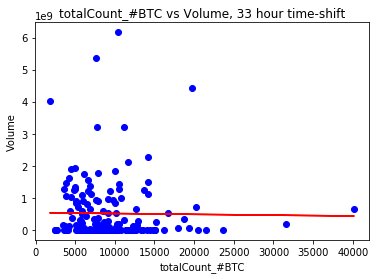

In [138]:
plt.title('totalCount_#BTC vs Volume, 33 hour time-shift')
plt.scatter(X2_shifted, y2_shifted, color='blue')
plt.plot(X2_shifted, lm.predict(X2_shifted), color='red')
plt.xlabel('totalCount_#BTC')
plt.ylabel('Volume')
plt.show()

This dramatic change in R^2 was clearly caused by an outlier.

In [139]:
#totalCount_Bitcoin vs Volume

# Split the data into a train/test set
X3 = bitcoin["totalCount_Bitcoin"].values[:,np.newaxis]
y3 = bitcoin["Volume"].values

In [140]:
lm.fit(X3, y3)
lm.score(X3, y3)

0.08711782327816664

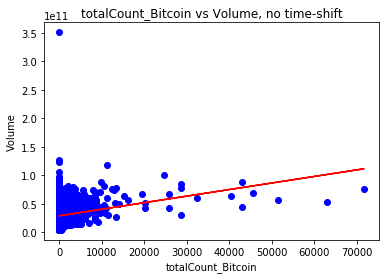

In [141]:
plt.title('totalCount_Bitcoin vs Volume, no time-shift')
plt.scatter(X3, y3, color='blue')
plt.plot(X3, lm.predict(X3), color='red')
plt.xlabel('totalCount_Bitcoin')
plt.ylabel('Volume')
plt.show()

In [142]:
y3_shifted = bitcoin['Volume'].shift(-10)
y3_shifted = y3_shifted[:-10]
X3_shifted = X3[:-10]

In [143]:
lm.fit(X3_shifted, y3_shifted)
lm.score(X3_shifted, y3_shifted)

0.15923054855806973

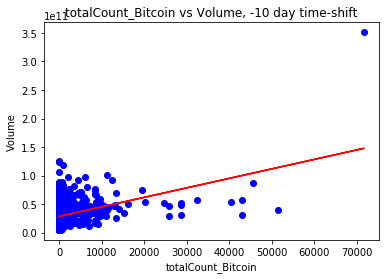

In [144]:
plt.title('totalCount_Bitcoin vs Volume, -10 day time-shift')
plt.scatter(X3_shifted, y3_shifted, color='blue')
plt.plot(X3_shifted, lm.predict(X3_shifted), color='red')
plt.xlabel('totalCount_Bitcoin')
plt.ylabel('Volume')
plt.show()

Outliers are messing up the trend line

In [145]:
#totalCount_Bitcoin vs Volume

# Split the data into a train/test set
X4 = bitcoin["totalCount_elonmusk"].values[:,np.newaxis]
y4 = bitcoin["Volume"].values

In [146]:
lm.fit(X4, y4)
lm.score(X4, y4)

0.0805501809768927

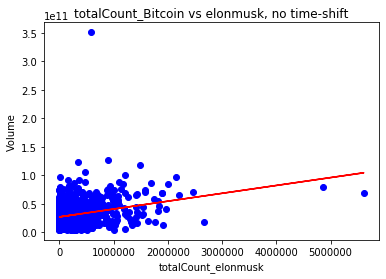

In [147]:
plt.title('totalCount_Bitcoin vs elonmusk, no time-shift')
plt.scatter(X4, y4, color='blue')
plt.plot(X4, lm.predict(X4), color='red')
plt.xlabel('totalCount_elonmusk')
plt.ylabel('Volume')
plt.show()

In [148]:
y4_shifted = bitcoin['Volume'].shift(-1)
y4_shifted = y4_shifted[:-1]
X4_shifted = X4[:-1]

In [149]:
lm.fit(X4_shifted, y4_shifted)
lm.score(X4_shifted, y4_shifted)

0.10884304844557857

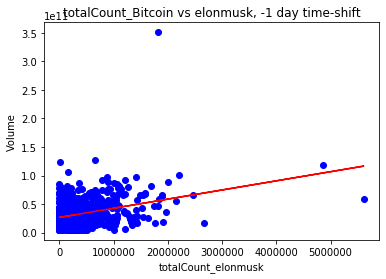

In [150]:
plt.title('totalCount_Bitcoin vs elonmusk, -1 day time-shift')
plt.scatter(X4_shifted, y4_shifted, color='blue')
plt.plot(X4_shifted, lm.predict(X4_shifted), color='red')
plt.xlabel('totalCount_elonmusk')
plt.ylabel('Volume')
plt.show()

Miniscule improvement in R^2, outliers seem to be affecting this pair as well.

## Section 6: Summary/Key Findings
[Back to Table of Contents](#Table-of-Contents)

All four pairs of variables are being affected by outliers. The first pair gave the best results, but the improved R^2 was only 0.14. The obvious improvement that can be made is the removal of outliers. A good next move would be to remove the outliers from the dataset and repeat the cross-correlation analysis to find new pairs of variables, then plot the linear regressions for those variables.

# ----------------------------End of Section 6----------------------------